### TFG AÑO- Cesar Hernandez Rodriguez
El estudio se hace con los datos historicos de año a año (252 dias), se realiza la prediccion de ciertos activos elegidos previamente, si se necesita cualquier otro activo del NASDAQ estan en los otros script ya que esto solo es una pequeña muestra representativa del funcionamiento

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice NASDAQ que es uno de los índices más importantes de Estados Unidos (índide tecnologico), siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

De este conjunto de datos solo voy a coger son $['AAPL', 'SNRC', 'ATVI', 'MINI', 'GOOG', 'BBOX']$ 

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. Al crearme una cuenta gratuita las opciones que se ofrecen no son las mias que para una cuenata premium por lo que cogere fechas pasadas y no actuales. 

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

A la hora de realizar el modelo creo 3 atributos, 2 medias moviles una de 10 dias y otra de 20 dias y un oscilador de la media movil de 20 dias.

Depues de realizar el modelo la idea de la practica es realizar una prueba real, por ello me fio del modelo que he obtenido e imaginando una inversion inical de 100000 euros dejo que la red neuronal haga lo que deba con ese dinero, decidiendo si quiere comprar, vender o mantener. Hay 3 formas programadas, compra a la alza, compra a la alza y a la baja y compra a la baja.

In [2]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
import keras.backend as K

# Conteo
from collections import Counter

# Graficos
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
plt.style.use('seaborn')

In [4]:
# Descarga de las bases los tickets de los activos que vamos a predecir con los csv de la carpeta
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-listed-symbols-TFG.csv')
    
    tickersQuandl = []    
    tickers = pd.DataFrame(columns = ['Symbol','CompanyName'], index = range(len(tickers_nasdaq)))

    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq['Symbol'][i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers['Symbol'][i] = word
                tickers['CompanyName'][i] = tickers_nasdaq['CompanyName'][i]
    
    for tick in tickers['Symbol']:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

#a,b = get_tickers_sample_nasdaq()

In [5]:
# Descargo de los datos con la API Quandl y la key propia
# Las fechas estan elegidas a convinencia para poder concatenar las fechas y que quede de seguido

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2009-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2015-12-01",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
        
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos_demo/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos_demo/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos_demo/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos_demo/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos_demo/nasdaq_testAño.p", "wb"))
    pickle.dump(datosClose_test, open("datos_demo/nasdaqClose_testAño.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [6]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos_demo/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos_demo/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos_demo/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos_demo/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos_demo/nasdaq_testAño.p", "rb" ))
    datosClose_test = pickle.load(open("datos_demo/nasdaqClose_testAño.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre['Symbol']].plot(figsize=(12,5),grid=True)
    plt.title('{} de la compañia {} {}\n'.format(nombre['Symbol'],nombre['CompanyName'],test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [7]:
datos_descargados = True
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a cargar los datos****

 ****Cargados los datos****


 ****Empezamos a cargar los datos test****

 ****Cargados los datos test****



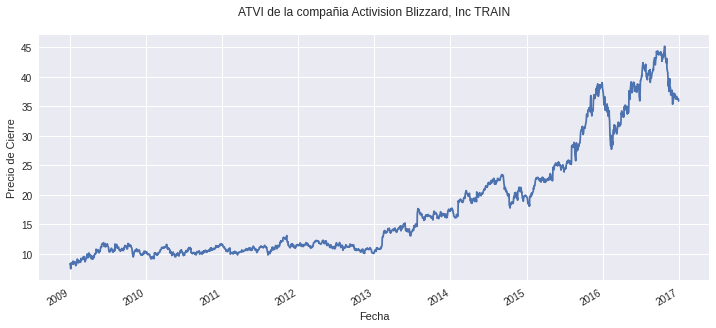

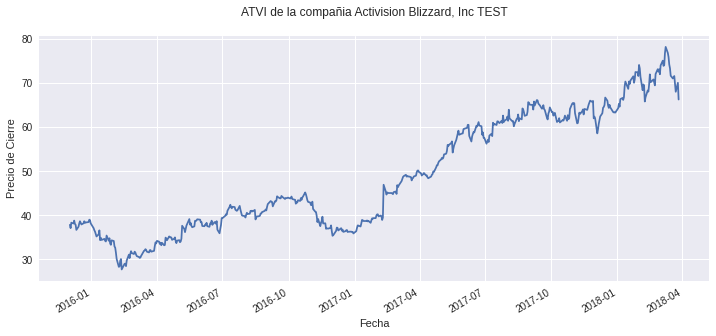

In [38]:
# Grafico un activo aleatorio 
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = 3
plot_datos(datosClose,tickers.iloc[ran],"TRAIN")
plot_datos(datosClose_test,tickers.iloc[ran],"TEST")

In [9]:
# Creacion de los atributos para la Red Neuronal Recurrente
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

In [10]:
# A parte de la creacion de atributos
index = ran
timeStep = 252 # longitud de secuencias que se hacen en cada iteracion de la red (un año entero)

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers['Symbol'][index]],10,20)
Y = pd.DataFrame(datosClose[tickers['Symbol'][index]].values[21:len(datosClose[tickers['Symbol'][index]])])
X = X.to_numpy()

# Creamos los atributos para los datos test
ticket_uso = tickers['Symbol'][index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers['Symbol'][index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers['Symbol'][index]].values[21:len(datosClose_test[tickers['Symbol'][index]])])
Xtesteo = Xtesteo.to_numpy()

# Junto todos los datos para poder hacer su correcta normalizacion
X_aux = np.concatenate((X,Xtesteo),axis=0)

scaler = MinMaxScaler()
X_aux_scaled = scaler.fit_transform(X_aux)
X_scaled = X_aux_scaled[0:len(X)]
Xtesteo_scaled = X_aux_scaled[len(X):len(X_aux_scaled)]

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


print("Voy a predecir el activo {} de la compañia {}".format(ticket_uso,tickers['CompanyName'][index]))

Voy a predecir el activo ATVI de la compañia Activision Blizzard, Inc


In [11]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

# Creacion de la red neural LSTM

In [19]:
model42 = Sequential()
model42.add(LSTM(4, input_shape=(252,3),return_sequences=True))
model42.add(LSTM(units = 2,return_sequences = False))
model42.add(Dense(1)) 
model42.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model42.summary()
history_LSTM42 = model42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 252, 4)            128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 14s 375ms/step - loss: 462.8428 - porcentaje_margen: 0.0000e+00 - val_loss: 458.0215 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 13s 350ms/step - loss: 455.0230 - porcentaje_margen: 0.0000e+00 - val_loss: 448.9511 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [==================

Epoch 91/1500
37/37 [==============================] - 12s 328ms/step - loss: 159.7489 - porcentaje_margen: 0.2272 - val_loss: 156.1822 - val_porcentaje_margen: 0.2382
Epoch 92/1500
37/37 [==============================] - 12s 329ms/step - loss: 158.4381 - porcentaje_margen: 0.2162 - val_loss: 154.8623 - val_porcentaje_margen: 0.2283
Epoch 93/1500
37/37 [==============================] - 12s 332ms/step - loss: 157.1467 - porcentaje_margen: 0.1917 - val_loss: 153.5746 - val_porcentaje_margen: 0.2020
Epoch 94/1500
37/37 [==============================] - 12s 327ms/step - loss: 155.8862 - porcentaje_margen: 0.1850 - val_loss: 152.3028 - val_porcentaje_margen: 0.1872
Epoch 95/1500
37/37 [==============================] - 12s 325ms/step - loss: 154.6509 - porcentaje_margen: 0.1715 - val_loss: 151.0504 - val_porcentaje_margen: 0.1773
Epoch 96/1500
37/37 [==============================] - 12s 330ms/step - loss: 153.4250 - porcentaje_margen: 0.1554 - val_loss: 149.8207 - val_porcentaje_margen:

Epoch 188/1500
37/37 [==============================] - 12s 330ms/step - loss: 101.4791 - porcentaje_margen: 0.0296 - val_loss: 97.4447 - val_porcentaje_margen: 0.0401
Epoch 189/1500
37/37 [==============================] - 12s 328ms/step - loss: 101.3641 - porcentaje_margen: 0.0312 - val_loss: 97.3203 - val_porcentaje_margen: 0.0418
Epoch 190/1500
37/37 [==============================] - 12s 330ms/step - loss: 101.2662 - porcentaje_margen: 0.0312 - val_loss: 97.2257 - val_porcentaje_margen: 0.0385
Epoch 191/1500
37/37 [==============================] - 12s 331ms/step - loss: 101.1777 - porcentaje_margen: 0.0270 - val_loss: 97.1278 - val_porcentaje_margen: 0.0385
Epoch 192/1500
37/37 [==============================] - 12s 325ms/step - loss: 101.0881 - porcentaje_margen: 0.0287 - val_loss: 97.0226 - val_porcentaje_margen: 0.0401
Epoch 193/1500
37/37 [==============================] - 12s 328ms/step - loss: 96.1695 - porcentaje_margen: 0.0557 - val_loss: 79.7470 - val_porcentaje_margen: 

37/37 [==============================] - 12s 330ms/step - loss: 45.3587 - porcentaje_margen: 0.4139 - val_loss: 43.6789 - val_porcentaje_margen: 0.4549
Epoch 238/1500
37/37 [==============================] - 12s 322ms/step - loss: 44.8243 - porcentaje_margen: 0.4164 - val_loss: 43.1610 - val_porcentaje_margen: 0.4467
Epoch 239/1500
37/37 [==============================] - 12s 331ms/step - loss: 44.3233 - porcentaje_margen: 0.4181 - val_loss: 42.6918 - val_porcentaje_margen: 0.4368
Epoch 240/1500
37/37 [==============================] - 12s 326ms/step - loss: 43.8129 - porcentaje_margen: 0.4054 - val_loss: 42.1984 - val_porcentaje_margen: 0.4434
Epoch 241/1500
37/37 [==============================] - 12s 328ms/step - loss: 43.2989 - porcentaje_margen: 0.4172 - val_loss: 41.7519 - val_porcentaje_margen: 0.4418
Epoch 242/1500
37/37 [==============================] - 12s 329ms/step - loss: 42.8356 - porcentaje_margen: 0.4079 - val_loss: 41.2882 - val_porcentaje_margen: 0.4681
Epoch 243/150

37/37 [==============================] - 11s 307ms/step - loss: 12.2403 - porcentaje_margen: 0.5490 - val_loss: 12.3565 - val_porcentaje_margen: 0.5816
Epoch 336/1500
37/37 [==============================] - 11s 308ms/step - loss: 12.0608 - porcentaje_margen: 0.5389 - val_loss: 12.1949 - val_porcentaje_margen: 0.5914
Epoch 337/1500
37/37 [==============================] - 11s 302ms/step - loss: 11.8799 - porcentaje_margen: 0.5465 - val_loss: 12.0749 - val_porcentaje_margen: 0.5849
Epoch 338/1500
37/37 [==============================] - 11s 308ms/step - loss: 11.6902 - porcentaje_margen: 0.5236 - val_loss: 11.8016 - val_porcentaje_margen: 0.5865
Epoch 339/1500
37/37 [==============================] - 11s 310ms/step - loss: 11.5100 - porcentaje_margen: 0.5448 - val_loss: 11.6286 - val_porcentaje_margen: 0.5905
Epoch 340/1500
37/37 [==============================] - 12s 312ms/step - loss: 11.3107 - porcentaje_margen: 0.5456 - val_loss: 11.4626 - val_porcentaje_margen: 0.5757
Epoch 341/150

Epoch 434/1500
37/37 [==============================] - 12s 315ms/step - loss: 2.9172 - porcentaje_margen: 0.6453 - val_loss: 3.2235 - val_porcentaje_margen: 0.6342
Epoch 435/1500
37/37 [==============================] - 12s 311ms/step - loss: 2.9128 - porcentaje_margen: 0.6351 - val_loss: 3.2090 - val_porcentaje_margen: 0.6737
Epoch 436/1500
37/37 [==============================] - 12s 313ms/step - loss: 2.8175 - porcentaje_margen: 0.6681 - val_loss: 3.4284 - val_porcentaje_margen: 0.6023
Epoch 437/1500
37/37 [==============================] - 11s 305ms/step - loss: 2.9441 - porcentaje_margen: 0.5929 - val_loss: 3.1100 - val_porcentaje_margen: 0.6901
Epoch 438/1500
37/37 [==============================] - 11s 307ms/step - loss: 2.7581 - porcentaje_margen: 0.6368 - val_loss: 3.0336 - val_porcentaje_margen: 0.6276
Epoch 439/1500
37/37 [==============================] - 12s 315ms/step - loss: 2.7397 - porcentaje_margen: 0.6453 - val_loss: 2.9779 - val_porcentaje_margen: 0.6951
Epoch 440/

Epoch 484/1500
37/37 [==============================] - 12s 317ms/step - loss: 1.6871 - porcentaje_margen: 0.6951 - val_loss: 1.7981 - val_porcentaje_margen: 0.7263
Epoch 485/1500
37/37 [==============================] - 11s 307ms/step - loss: 1.6458 - porcentaje_margen: 0.7188 - val_loss: 1.6920 - val_porcentaje_margen: 0.7214
Epoch 486/1500
37/37 [==============================] - 11s 307ms/step - loss: 1.6335 - porcentaje_margen: 0.7086 - val_loss: 1.7315 - val_porcentaje_margen: 0.7230
Epoch 487/1500
37/37 [==============================] - 11s 305ms/step - loss: 1.6373 - porcentaje_margen: 0.7052 - val_loss: 1.6823 - val_porcentaje_margen: 0.6951
Epoch 488/1500
37/37 [==============================] - 11s 309ms/step - loss: 1.6095 - porcentaje_margen: 0.7061 - val_loss: 1.6605 - val_porcentaje_margen: 0.7148
Epoch 489/1500
37/37 [==============================] - 11s 310ms/step - loss: 1.6345 - porcentaje_margen: 0.6909 - val_loss: 1.7357 - val_porcentaje_margen: 0.7280
Epoch 490/

Epoch 534/1500
37/37 [==============================] - 12s 314ms/step - loss: 1.2534 - porcentaje_margen: 0.7475 - val_loss: 1.1876 - val_porcentaje_margen: 0.7740
Epoch 535/1500
37/37 [==============================] - 12s 311ms/step - loss: 1.2576 - porcentaje_margen: 0.7297 - val_loss: 1.1953 - val_porcentaje_margen: 0.7164
Epoch 536/1500
37/37 [==============================] - 11s 308ms/step - loss: 1.3079 - porcentaje_margen: 0.7340 - val_loss: 1.1418 - val_porcentaje_margen: 0.7658
Epoch 537/1500
37/37 [==============================] - 11s 307ms/step - loss: 1.2845 - porcentaje_margen: 0.7095 - val_loss: 1.1890 - val_porcentaje_margen: 0.7961
Epoch 538/1500
37/37 [==============================] - 11s 309ms/step - loss: 1.2922 - porcentaje_margen: 0.7306 - val_loss: 1.1556 - val_porcentaje_margen: 0.7641
Epoch 539/1500
37/37 [==============================] - 11s 309ms/step - loss: 1.1877 - porcentaje_margen: 0.7534 - val_loss: 1.1235 - val_porcentaje_margen: 0.7862
Epoch 540/

Epoch 584/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.9556 - porcentaje_margen: 0.7939 - val_loss: 0.8630 - val_porcentaje_margen: 0.8020
Epoch 585/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.9646 - porcentaje_margen: 0.7880 - val_loss: 0.8903 - val_porcentaje_margen: 0.7822
Epoch 586/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.9302 - porcentaje_margen: 0.7990 - val_loss: 0.9038 - val_porcentaje_margen: 0.8240
Epoch 587/1500
37/37 [==============================] - 11s 310ms/step - loss: 0.9397 - porcentaje_margen: 0.8041 - val_loss: 0.9765 - val_porcentaje_margen: 0.8151
Epoch 588/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.9502 - porcentaje_margen: 0.7863 - val_loss: 0.8766 - val_porcentaje_margen: 0.8322
Epoch 589/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.9312 - porcentaje_margen: 0.7956 - val_loss: 1.1005 - val_porcentaje_margen: 0.7516
Epoch 590/

Epoch 634/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.7660 - porcentaje_margen: 0.8429 - val_loss: 0.7781 - val_porcentaje_margen: 0.7872
Epoch 635/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.8098 - porcentaje_margen: 0.8015 - val_loss: 0.7633 - val_porcentaje_margen: 0.8520
Epoch 636/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.7777 - porcentaje_margen: 0.8218 - val_loss: 0.8086 - val_porcentaje_margen: 0.8438
Epoch 637/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.7773 - porcentaje_margen: 0.8260 - val_loss: 0.7034 - val_porcentaje_margen: 0.8635
Epoch 638/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.7615 - porcentaje_margen: 0.8353 - val_loss: 0.6818 - val_porcentaje_margen: 0.8618
Epoch 639/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.7718 - porcentaje_margen: 0.8302 - val_loss: 0.6754 - val_porcentaje_margen: 0.8635
Epoch 640/

Epoch 684/1500
37/37 [==============================] - 12s 330ms/step - loss: 0.6632 - porcentaje_margen: 0.8446 - val_loss: 0.7579 - val_porcentaje_margen: 0.8536
Epoch 685/1500
37/37 [==============================] - 12s 326ms/step - loss: 0.7054 - porcentaje_margen: 0.8209 - val_loss: 0.6009 - val_porcentaje_margen: 0.8684
Epoch 686/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.6721 - porcentaje_margen: 0.8522 - val_loss: 0.6620 - val_porcentaje_margen: 0.8766
Epoch 687/1500
37/37 [==============================] - 12s 312ms/step - loss: 0.6442 - porcentaje_margen: 0.8725 - val_loss: 0.6494 - val_porcentaje_margen: 0.8750
Epoch 688/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.6478 - porcentaje_margen: 0.8581 - val_loss: 0.6381 - val_porcentaje_margen: 0.8783
Epoch 689/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.6596 - porcentaje_margen: 0.8547 - val_loss: 0.5998 - val_porcentaje_margen: 0.8651
Epoch 690/

Epoch 734/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.5845 - porcentaje_margen: 0.8691 - val_loss: 0.5759 - val_porcentaje_margen: 0.8783
Epoch 735/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.5812 - porcentaje_margen: 0.8699 - val_loss: 0.6628 - val_porcentaje_margen: 0.8750
Epoch 736/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.5870 - porcentaje_margen: 0.8623 - val_loss: 0.5363 - val_porcentaje_margen: 0.8980
Epoch 737/1500
37/37 [==============================] - 12s 311ms/step - loss: 0.5833 - porcentaje_margen: 0.8581 - val_loss: 0.5843 - val_porcentaje_margen: 0.8783
Epoch 738/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.5687 - porcentaje_margen: 0.8742 - val_loss: 0.6567 - val_porcentaje_margen: 0.8372
Epoch 739/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.5916 - porcentaje_margen: 0.8632 - val_loss: 0.5950 - val_porcentaje_margen: 0.8898
Epoch 740/

Epoch 784/1500
37/37 [==============================] - 12s 313ms/step - loss: 0.5270 - porcentaje_margen: 0.9029 - val_loss: 0.4848 - val_porcentaje_margen: 0.9095
Epoch 785/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.5323 - porcentaje_margen: 0.8910 - val_loss: 0.6720 - val_porcentaje_margen: 0.8322
Epoch 786/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.5424 - porcentaje_margen: 0.8843 - val_loss: 0.5308 - val_porcentaje_margen: 0.8997
Epoch 787/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.5458 - porcentaje_margen: 0.8894 - val_loss: 0.6052 - val_porcentaje_margen: 0.7536
Epoch 788/1500
37/37 [==============================] - 12s 325ms/step - loss: 0.5586 - porcentaje_margen: 0.8606 - val_loss: 0.4975 - val_porcentaje_margen: 0.9013
Epoch 789/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.5166 - porcentaje_margen: 0.9003 - val_loss: 0.4870 - val_porcentaje_margen: 0.9062
Epoch 790/

Epoch 834/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.4988 - porcentaje_margen: 0.9088 - val_loss: 0.4722 - val_porcentaje_margen: 0.9056
Epoch 835/1500
37/37 [==============================] - 12s 315ms/step - loss: 0.4916 - porcentaje_margen: 0.9105 - val_loss: 0.4851 - val_porcentaje_margen: 0.9161
Epoch 836/1500
37/37 [==============================] - 12s 324ms/step - loss: 0.4937 - porcentaje_margen: 0.8877 - val_loss: 0.5098 - val_porcentaje_margen: 0.9145
Epoch 837/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.4895 - porcentaje_margen: 0.9096 - val_loss: 0.5491 - val_porcentaje_margen: 0.8997
Epoch 838/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.5033 - porcentaje_margen: 0.9071 - val_loss: 0.6035 - val_porcentaje_margen: 0.8849
Epoch 839/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.5107 - porcentaje_margen: 0.8809 - val_loss: 0.4652 - val_porcentaje_margen: 0.9023
Epoch 840/

Epoch 884/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.4868 - porcentaje_margen: 0.8995 - val_loss: 0.5344 - val_porcentaje_margen: 0.8914
Epoch 885/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.4744 - porcentaje_margen: 0.9130 - val_loss: 0.5015 - val_porcentaje_margen: 0.9161
Epoch 886/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.4980 - porcentaje_margen: 0.8843 - val_loss: 0.5126 - val_porcentaje_margen: 0.8964
Epoch 887/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.4849 - porcentaje_margen: 0.9079 - val_loss: 0.4773 - val_porcentaje_margen: 0.9023
Epoch 888/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.4810 - porcentaje_margen: 0.9062 - val_loss: 0.4600 - val_porcentaje_margen: 0.9145
Epoch 889/1500
37/37 [==============================] - 12s 325ms/step - loss: 0.4782 - porcentaje_margen: 0.9046 - val_loss: 0.4708 - val_porcentaje_margen: 0.9030
Epoch 890/

Epoch 934/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.4771 - porcentaje_margen: 0.9105 - val_loss: 0.5063 - val_porcentaje_margen: 0.8914
Epoch 935/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.4946 - porcentaje_margen: 0.8936 - val_loss: 0.4748 - val_porcentaje_margen: 0.9178
Epoch 936/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.4714 - porcentaje_margen: 0.9164 - val_loss: 0.5255 - val_porcentaje_margen: 0.8734
Epoch 937/1500
37/37 [==============================] - 12s 315ms/step - loss: 0.4748 - porcentaje_margen: 0.9122 - val_loss: 0.4909 - val_porcentaje_margen: 0.9112
Epoch 938/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.4661 - porcentaje_margen: 0.9147 - val_loss: 0.4821 - val_porcentaje_margen: 0.9079
Epoch 939/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.4791 - porcentaje_margen: 0.9062 - val_loss: 0.4507 - val_porcentaje_margen: 0.9105
Epoch 940/

Epoch 984/1500
37/37 [==============================] - 12s 329ms/step - loss: 0.4765 - porcentaje_margen: 0.9105 - val_loss: 0.4445 - val_porcentaje_margen: 0.9155
Epoch 985/1500
37/37 [==============================] - 12s 327ms/step - loss: 0.4554 - porcentaje_margen: 0.9181 - val_loss: 0.4563 - val_porcentaje_margen: 0.9056
Epoch 986/1500
37/37 [==============================] - 12s 328ms/step - loss: 0.4806 - porcentaje_margen: 0.8970 - val_loss: 0.5656 - val_porcentaje_margen: 0.8447
Epoch 987/1500
37/37 [==============================] - 12s 325ms/step - loss: 0.4795 - porcentaje_margen: 0.8995 - val_loss: 0.4968 - val_porcentaje_margen: 0.8964
Epoch 988/1500
37/37 [==============================] - 12s 327ms/step - loss: 0.4538 - porcentaje_margen: 0.9164 - val_loss: 0.4623 - val_porcentaje_margen: 0.9095
Epoch 989/1500
37/37 [==============================] - 12s 324ms/step - loss: 0.4609 - porcentaje_margen: 0.9130 - val_loss: 0.4626 - val_porcentaje_margen: 0.8924
Epoch 990/

37/37 [==============================] - 12s 319ms/step - loss: 0.4458 - porcentaje_margen: 0.9299 - val_loss: 0.4680 - val_porcentaje_margen: 0.9128
Epoch 1083/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.4488 - porcentaje_margen: 0.9189 - val_loss: 0.4666 - val_porcentaje_margen: 0.9145
Epoch 1084/1500
37/37 [==============================] - 12s 326ms/step - loss: 0.4659 - porcentaje_margen: 0.9071 - val_loss: 0.5108 - val_porcentaje_margen: 0.9145
Epoch 1085/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.4508 - porcentaje_margen: 0.9181 - val_loss: 0.4960 - val_porcentaje_margen: 0.9095
Epoch 1086/1500
37/37 [==============================] - 12s 325ms/step - loss: 0.4731 - porcentaje_margen: 0.9020 - val_loss: 0.4726 - val_porcentaje_margen: 0.9227
Epoch 1087/1500
37/37 [==============================] - 12s 334ms/step - loss: 0.4438 - porcentaje_margen: 0.9282 - val_loss: 0.4342 - val_porcentaje_margen: 0.9227
Epoch 1088/1500
37/3

37/37 [==============================] - 12s 316ms/step - loss: 0.4395 - porcentaje_margen: 0.9172 - val_loss: 0.4245 - val_porcentaje_margen: 0.9276
Epoch 1181/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.4580 - porcentaje_margen: 0.9105 - val_loss: 0.4207 - val_porcentaje_margen: 0.9326
Epoch 1182/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.4531 - porcentaje_margen: 0.9215 - val_loss: 0.4446 - val_porcentaje_margen: 0.9243
Epoch 1183/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.4665 - porcentaje_margen: 0.9054 - val_loss: 0.5694 - val_porcentaje_margen: 0.8734
Epoch 1184/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.4393 - porcentaje_margen: 0.9223 - val_loss: 0.4186 - val_porcentaje_margen: 0.9270
Epoch 1185/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.4470 - porcentaje_margen: 0.9122 - val_loss: 0.4667 - val_porcentaje_margen: 0.8480
Epoch 1186/1500
37/3

37/37 [==============================] - 12s 318ms/step - loss: 0.4419 - porcentaje_margen: 0.9164 - val_loss: 0.4188 - val_porcentaje_margen: 0.9260
Epoch 1279/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.4348 - porcentaje_margen: 0.9139 - val_loss: 0.4285 - val_porcentaje_margen: 0.9243
Epoch 1280/1500
37/37 [==============================] - 12s 325ms/step - loss: 0.4357 - porcentaje_margen: 0.9215 - val_loss: 0.4119 - val_porcentaje_margen: 0.9408
Epoch 1281/1500
37/37 [==============================] - 12s 314ms/step - loss: 0.4292 - porcentaje_margen: 0.9231 - val_loss: 0.4248 - val_porcentaje_margen: 0.9326
Epoch 1282/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.4369 - porcentaje_margen: 0.9172 - val_loss: 0.4115 - val_porcentaje_margen: 0.9375
Epoch 1283/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.4529 - porcentaje_margen: 0.9172 - val_loss: 0.4514 - val_porcentaje_margen: 0.9095
Epoch 1284/1500
37/3

37/37 [==============================] - 12s 316ms/step - loss: 0.4374 - porcentaje_margen: 0.9181 - val_loss: 0.4444 - val_porcentaje_margen: 0.9046
Epoch 1377/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.4261 - porcentaje_margen: 0.9181 - val_loss: 0.5030 - val_porcentaje_margen: 0.8832
Epoch 1378/1500
37/37 [==============================] - 12s 311ms/step - loss: 0.4418 - porcentaje_margen: 0.9147 - val_loss: 0.4122 - val_porcentaje_margen: 0.9391
Epoch 1379/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.4382 - porcentaje_margen: 0.9240 - val_loss: 0.4219 - val_porcentaje_margen: 0.9359
Epoch 1380/1500
37/37 [==============================] - 12s 325ms/step - loss: 0.4291 - porcentaje_margen: 0.9265 - val_loss: 0.4083 - val_porcentaje_margen: 0.9408
Epoch 1381/1500
37/37 [==============================] - 12s 314ms/step - loss: 0.4239 - porcentaje_margen: 0.9231 - val_loss: 0.4349 - val_porcentaje_margen: 0.9326
Epoch 1382/1500
37/3

37/37 [==============================] - 12s 325ms/step - loss: 0.4180 - porcentaje_margen: 0.9265 - val_loss: 0.4510 - val_porcentaje_margen: 0.9260
Epoch 1475/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.4239 - porcentaje_margen: 0.9223 - val_loss: 0.4838 - val_porcentaje_margen: 0.9062
Epoch 1476/1500
37/37 [==============================] - 12s 336ms/step - loss: 0.4358 - porcentaje_margen: 0.9105 - val_loss: 0.4824 - val_porcentaje_margen: 0.8997
Epoch 1477/1500
37/37 [==============================] - 12s 330ms/step - loss: 0.4148 - porcentaje_margen: 0.9299 - val_loss: 0.4465 - val_porcentaje_margen: 0.9145
Epoch 1478/1500
37/37 [==============================] - 12s 327ms/step - loss: 0.4188 - porcentaje_margen: 0.9341 - val_loss: 0.4380 - val_porcentaje_margen: 0.9342
Epoch 1479/1500
37/37 [==============================] - 12s 331ms/step - loss: 0.4188 - porcentaje_margen: 0.9324 - val_loss: 0.4139 - val_porcentaje_margen: 0.9342
Epoch 1480/1500
37/3

In [20]:
model84 = Sequential()
model84.add(LSTM(8, input_shape=(252,3),return_sequences=True))
model84.add(LSTM(units = 4,return_sequences = False))
model84.add(Dense(1)) 
model84.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model84.summary()
history_84 = model84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 252, 8)            384       
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 597
Trainable params: 597
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 17s 455ms/step - loss: 442.1406 - porcentaje_margen: 0.0000e+00 - val_loss: 422.2803 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 15s 411ms/step - loss: 411.1815 - porcentaje_margen: 0.0000e+00 - val_loss: 399.0686 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [================

Epoch 44/1500
37/37 [==============================] - 14s 391ms/step - loss: 177.4736 - porcentaje_margen: 0.1740 - val_loss: 173.4308 - val_porcentaje_margen: 0.1717
Epoch 45/1500
37/37 [==============================] - 15s 396ms/step - loss: 174.9687 - porcentaje_margen: 0.1934 - val_loss: 170.9742 - val_porcentaje_margen: 0.2095
Epoch 46/1500
37/37 [==============================] - 14s 390ms/step - loss: 172.5467 - porcentaje_margen: 0.2238 - val_loss: 168.4862 - val_porcentaje_margen: 0.2293
Epoch 47/1500
37/37 [==============================] - 15s 392ms/step - loss: 170.1469 - porcentaje_margen: 0.2534 - val_loss: 166.1391 - val_porcentaje_margen: 0.2359
Epoch 48/1500
37/37 [==============================] - 14s 390ms/step - loss: 167.8275 - porcentaje_margen: 0.2534 - val_loss: 163.8017 - val_porcentaje_margen: 0.2391
Epoch 49/1500
37/37 [==============================] - 14s 392ms/step - loss: 165.5529 - porcentaje_margen: 0.2500 - val_loss: 161.5529 - val_porcentaje_margen:

Epoch 93/1500
37/37 [==============================] - 14s 384ms/step - loss: 109.2106 - porcentaje_margen: 0.0481 - val_loss: 105.2483 - val_porcentaje_margen: 0.0664
Epoch 94/1500
37/37 [==============================] - 14s 383ms/step - loss: 108.6807 - porcentaje_margen: 0.0574 - val_loss: 104.7122 - val_porcentaje_margen: 0.0730
Epoch 95/1500
37/37 [==============================] - 14s 382ms/step - loss: 108.1751 - porcentaje_margen: 0.0600 - val_loss: 104.1909 - val_porcentaje_margen: 0.0747
Epoch 96/1500
37/37 [==============================] - 14s 382ms/step - loss: 107.6794 - porcentaje_margen: 0.0600 - val_loss: 103.7212 - val_porcentaje_margen: 0.0763
Epoch 97/1500
37/37 [==============================] - 14s 381ms/step - loss: 107.2220 - porcentaje_margen: 0.0608 - val_loss: 103.2626 - val_porcentaje_margen: 0.0796
Epoch 98/1500
37/37 [==============================] - 14s 391ms/step - loss: 106.7809 - porcentaje_margen: 0.0642 - val_loss: 102.7722 - val_porcentaje_margen:

Epoch 142/1500
37/37 [==============================] - 14s 385ms/step - loss: 99.8270 - porcentaje_margen: 0.0456 - val_loss: 95.6716 - val_porcentaje_margen: 0.0395
Epoch 143/1500
37/37 [==============================] - 15s 395ms/step - loss: 99.8066 - porcentaje_margen: 0.0456 - val_loss: 95.6536 - val_porcentaje_margen: 0.0378
Epoch 144/1500
37/37 [==============================] - 14s 383ms/step - loss: 99.7907 - porcentaje_margen: 0.0507 - val_loss: 95.6293 - val_porcentaje_margen: 0.0395
Epoch 145/1500
37/37 [==============================] - 14s 384ms/step - loss: 99.7756 - porcentaje_margen: 0.0507 - val_loss: 95.6124 - val_porcentaje_margen: 0.0395
Epoch 146/1500
37/37 [==============================] - 15s 393ms/step - loss: 99.7617 - porcentaje_margen: 0.0498 - val_loss: 95.5952 - val_porcentaje_margen: 0.0395
Epoch 147/1500
37/37 [==============================] - 14s 392ms/step - loss: 99.7494 - porcentaje_margen: 0.0532 - val_loss: 95.5852 - val_porcentaje_margen: 0.039

37/37 [==============================] - 14s 390ms/step - loss: 43.3794 - porcentaje_margen: 0.5253 - val_loss: 41.4700 - val_porcentaje_margen: 0.5349
Epoch 192/1500
37/37 [==============================] - 14s 385ms/step - loss: 42.3344 - porcentaje_margen: 0.5279 - val_loss: 40.4648 - val_porcentaje_margen: 0.5257
Epoch 193/1500
37/37 [==============================] - 14s 387ms/step - loss: 41.2831 - porcentaje_margen: 0.5557 - val_loss: 39.5174 - val_porcentaje_margen: 0.5563
Epoch 194/1500
37/37 [==============================] - 14s 378ms/step - loss: 40.3240 - porcentaje_margen: 0.5228 - val_loss: 38.6903 - val_porcentaje_margen: 0.4905
Epoch 195/1500
37/37 [==============================] - 14s 383ms/step - loss: 39.3974 - porcentaje_margen: 0.5194 - val_loss: 37.6763 - val_porcentaje_margen: 0.5816
Epoch 196/1500
37/37 [==============================] - 14s 384ms/step - loss: 38.4404 - porcentaje_margen: 0.5524 - val_loss: 36.8012 - val_porcentaje_margen: 0.5727
Epoch 197/150

37/37 [==============================] - 15s 393ms/step - loss: 4.2946 - porcentaje_margen: 0.6740 - val_loss: 4.5962 - val_porcentaje_margen: 0.7418
Epoch 290/1500
37/37 [==============================] - 14s 389ms/step - loss: 4.2116 - porcentaje_margen: 0.6791 - val_loss: 4.6000 - val_porcentaje_margen: 0.6957
Epoch 291/1500
37/37 [==============================] - 15s 393ms/step - loss: 4.0686 - porcentaje_margen: 0.6883 - val_loss: 4.4770 - val_porcentaje_margen: 0.6918
Epoch 292/1500
37/37 [==============================] - 14s 391ms/step - loss: 4.0217 - porcentaje_margen: 0.6731 - val_loss: 4.2985 - val_porcentaje_margen: 0.7280
Epoch 293/1500
37/37 [==============================] - 14s 391ms/step - loss: 3.8888 - porcentaje_margen: 0.7027 - val_loss: 4.2671 - val_porcentaje_margen: 0.7000
Epoch 294/1500
37/37 [==============================] - 14s 388ms/step - loss: 3.8567 - porcentaje_margen: 0.6926 - val_loss: 4.2057 - val_porcentaje_margen: 0.7303
Epoch 295/1500
37/37 [===

Epoch 339/1500
37/37 [==============================] - 14s 382ms/step - loss: 1.6579 - porcentaje_margen: 0.7593 - val_loss: 1.8127 - val_porcentaje_margen: 0.7878
Epoch 340/1500
37/37 [==============================] - 14s 388ms/step - loss: 1.6010 - porcentaje_margen: 0.7652 - val_loss: 1.7224 - val_porcentaje_margen: 0.7911
Epoch 341/1500
37/37 [==============================] - 14s 384ms/step - loss: 1.5547 - porcentaje_margen: 0.7762 - val_loss: 1.6761 - val_porcentaje_margen: 0.7862
Epoch 342/1500
37/37 [==============================] - 14s 382ms/step - loss: 1.5381 - porcentaje_margen: 0.7787 - val_loss: 1.7945 - val_porcentaje_margen: 0.6312
Epoch 343/1500
37/37 [==============================] - 14s 383ms/step - loss: 1.5702 - porcentaje_margen: 0.7542 - val_loss: 1.5987 - val_porcentaje_margen: 0.7944
Epoch 344/1500
37/37 [==============================] - 14s 381ms/step - loss: 1.5572 - porcentaje_margen: 0.7610 - val_loss: 1.8243 - val_porcentaje_margen: 0.6132
Epoch 345/

Epoch 389/1500
37/37 [==============================] - 14s 381ms/step - loss: 0.8690 - porcentaje_margen: 0.8142 - val_loss: 0.9526 - val_porcentaje_margen: 0.8158
Epoch 390/1500
37/37 [==============================] - 14s 383ms/step - loss: 0.8738 - porcentaje_margen: 0.8057 - val_loss: 0.8767 - val_porcentaje_margen: 0.7888
Epoch 391/1500
37/37 [==============================] - 14s 386ms/step - loss: 0.8603 - porcentaje_margen: 0.8176 - val_loss: 0.8477 - val_porcentaje_margen: 0.8151
Epoch 392/1500
37/37 [==============================] - 14s 388ms/step - loss: 0.8637 - porcentaje_margen: 0.8159 - val_loss: 1.1093 - val_porcentaje_margen: 0.7549
Epoch 393/1500
37/37 [==============================] - 14s 388ms/step - loss: 0.8697 - porcentaje_margen: 0.8074 - val_loss: 0.8966 - val_porcentaje_margen: 0.8355
Epoch 394/1500
37/37 [==============================] - 14s 388ms/step - loss: 0.8565 - porcentaje_margen: 0.8083 - val_loss: 0.8191 - val_porcentaje_margen: 0.8421
Epoch 395/

Epoch 439/1500
37/37 [==============================] - 14s 387ms/step - loss: 0.6374 - porcentaje_margen: 0.8471 - val_loss: 0.6295 - val_porcentaje_margen: 0.8832
Epoch 440/1500
37/37 [==============================] - 14s 391ms/step - loss: 0.6353 - porcentaje_margen: 0.8615 - val_loss: 0.6886 - val_porcentaje_margen: 0.8503
Epoch 441/1500
37/37 [==============================] - 14s 388ms/step - loss: 0.6669 - porcentaje_margen: 0.8429 - val_loss: 0.6289 - val_porcentaje_margen: 0.8684
Epoch 442/1500
37/37 [==============================] - 14s 382ms/step - loss: 0.6217 - porcentaje_margen: 0.8606 - val_loss: 0.6431 - val_porcentaje_margen: 0.8799
Epoch 443/1500
37/37 [==============================] - 14s 383ms/step - loss: 0.6383 - porcentaje_margen: 0.8311 - val_loss: 0.5981 - val_porcentaje_margen: 0.8832
Epoch 444/1500
37/37 [==============================] - 14s 383ms/step - loss: 0.6459 - porcentaje_margen: 0.8530 - val_loss: 0.6811 - val_porcentaje_margen: 0.8635
Epoch 445/

Epoch 489/1500
37/37 [==============================] - 14s 384ms/step - loss: 0.5350 - porcentaje_margen: 0.8860 - val_loss: 0.5514 - val_porcentaje_margen: 0.8964
Epoch 490/1500
37/37 [==============================] - 14s 389ms/step - loss: 0.5551 - porcentaje_margen: 0.8801 - val_loss: 0.6678 - val_porcentaje_margen: 0.8273
Epoch 491/1500
37/37 [==============================] - 14s 381ms/step - loss: 0.5750 - porcentaje_margen: 0.8505 - val_loss: 0.5447 - val_porcentaje_margen: 0.8832
Epoch 492/1500
37/37 [==============================] - 14s 382ms/step - loss: 0.5500 - porcentaje_margen: 0.8606 - val_loss: 0.5767 - val_porcentaje_margen: 0.8914
Epoch 493/1500
37/37 [==============================] - 14s 384ms/step - loss: 0.5492 - porcentaje_margen: 0.8674 - val_loss: 0.5435 - val_porcentaje_margen: 0.8914
Epoch 494/1500
37/37 [==============================] - 14s 390ms/step - loss: 0.5281 - porcentaje_margen: 0.8826 - val_loss: 0.5328 - val_porcentaje_margen: 0.8849
Epoch 495/

Epoch 539/1500
37/37 [==============================] - 14s 388ms/step - loss: 0.5111 - porcentaje_margen: 0.8725 - val_loss: 0.7034 - val_porcentaje_margen: 0.8076
Epoch 540/1500
37/37 [==============================] - 14s 379ms/step - loss: 0.5108 - porcentaje_margen: 0.8851 - val_loss: 0.5279 - val_porcentaje_margen: 0.8865
Epoch 541/1500
37/37 [==============================] - 14s 375ms/step - loss: 0.4873 - porcentaje_margen: 0.8885 - val_loss: 0.4839 - val_porcentaje_margen: 0.9095
Epoch 542/1500
37/37 [==============================] - 14s 374ms/step - loss: 0.4982 - porcentaje_margen: 0.8801 - val_loss: 0.4897 - val_porcentaje_margen: 0.9095
Epoch 543/1500
37/37 [==============================] - 14s 381ms/step - loss: 0.4963 - porcentaje_margen: 0.8902 - val_loss: 0.4977 - val_porcentaje_margen: 0.8964
Epoch 544/1500
37/37 [==============================] - 14s 389ms/step - loss: 0.5017 - porcentaje_margen: 0.8902 - val_loss: 0.4999 - val_porcentaje_margen: 0.9046
Epoch 545/

Epoch 589/1500
37/37 [==============================] - 14s 383ms/step - loss: 0.4757 - porcentaje_margen: 0.8953 - val_loss: 0.4637 - val_porcentaje_margen: 0.9062
Epoch 590/1500
37/37 [==============================] - 14s 378ms/step - loss: 0.4621 - porcentaje_margen: 0.8894 - val_loss: 0.4577 - val_porcentaje_margen: 0.9309
Epoch 591/1500
37/37 [==============================] - 14s 372ms/step - loss: 0.4461 - porcentaje_margen: 0.9096 - val_loss: 0.4509 - val_porcentaje_margen: 0.9013
Epoch 592/1500
37/37 [==============================] - 14s 377ms/step - loss: 0.4667 - porcentaje_margen: 0.9037 - val_loss: 0.4495 - val_porcentaje_margen: 0.9260
Epoch 593/1500
37/37 [==============================] - 14s 378ms/step - loss: 0.4588 - porcentaje_margen: 0.8936 - val_loss: 0.4316 - val_porcentaje_margen: 0.9211
Epoch 594/1500
37/37 [==============================] - 14s 382ms/step - loss: 0.4405 - porcentaje_margen: 0.9147 - val_loss: 0.5702 - val_porcentaje_margen: 0.9079
Epoch 595/

Epoch 639/1500
37/37 [==============================] - 14s 378ms/step - loss: 0.4156 - porcentaje_margen: 0.9155 - val_loss: 0.4031 - val_porcentaje_margen: 0.9161
Epoch 640/1500
37/37 [==============================] - 14s 384ms/step - loss: 0.4159 - porcentaje_margen: 0.9088 - val_loss: 0.4199 - val_porcentaje_margen: 0.9326
Epoch 641/1500
37/37 [==============================] - 14s 374ms/step - loss: 0.4649 - porcentaje_margen: 0.8767 - val_loss: 0.6497 - val_porcentaje_margen: 0.7454
Epoch 642/1500
37/37 [==============================] - 14s 389ms/step - loss: 0.4328 - porcentaje_margen: 0.8936 - val_loss: 0.4005 - val_porcentaje_margen: 0.9309
Epoch 643/1500
37/37 [==============================] - 14s 380ms/step - loss: 0.4189 - porcentaje_margen: 0.9046 - val_loss: 0.4521 - val_porcentaje_margen: 0.9276
Epoch 644/1500
37/37 [==============================] - 14s 382ms/step - loss: 0.4307 - porcentaje_margen: 0.9155 - val_loss: 0.4140 - val_porcentaje_margen: 0.9062
Epoch 645/

Epoch 689/1500
37/37 [==============================] - 14s 380ms/step - loss: 0.4362 - porcentaje_margen: 0.9020 - val_loss: 0.5564 - val_porcentaje_margen: 0.9046
Epoch 690/1500
37/37 [==============================] - 14s 374ms/step - loss: 0.4172 - porcentaje_margen: 0.9046 - val_loss: 0.4411 - val_porcentaje_margen: 0.9079
Epoch 691/1500
37/37 [==============================] - 14s 371ms/step - loss: 0.3957 - porcentaje_margen: 0.9164 - val_loss: 0.4022 - val_porcentaje_margen: 0.9326
Epoch 692/1500
37/37 [==============================] - 14s 381ms/step - loss: 0.4057 - porcentaje_margen: 0.9071 - val_loss: 0.4304 - val_porcentaje_margen: 0.8980
Epoch 693/1500
37/37 [==============================] - 14s 380ms/step - loss: 0.4096 - porcentaje_margen: 0.9147 - val_loss: 0.3996 - val_porcentaje_margen: 0.9293
Epoch 694/1500
37/37 [==============================] - 14s 377ms/step - loss: 0.3925 - porcentaje_margen: 0.9155 - val_loss: 0.4439 - val_porcentaje_margen: 0.9178
Epoch 695/

Epoch 739/1500
37/37 [==============================] - 14s 380ms/step - loss: 0.3863 - porcentaje_margen: 0.9198 - val_loss: 0.3876 - val_porcentaje_margen: 0.9204
Epoch 740/1500
37/37 [==============================] - 14s 376ms/step - loss: 0.4076 - porcentaje_margen: 0.9155 - val_loss: 0.4854 - val_porcentaje_margen: 0.8299
Epoch 741/1500
37/37 [==============================] - 14s 376ms/step - loss: 0.4173 - porcentaje_margen: 0.9054 - val_loss: 0.5079 - val_porcentaje_margen: 0.9227
Epoch 742/1500
37/37 [==============================] - 14s 373ms/step - loss: 0.4216 - porcentaje_margen: 0.9003 - val_loss: 0.3974 - val_porcentaje_margen: 0.9138
Epoch 743/1500
37/37 [==============================] - 14s 375ms/step - loss: 0.3840 - porcentaje_margen: 0.9189 - val_loss: 0.3919 - val_porcentaje_margen: 0.9309
Epoch 744/1500
37/37 [==============================] - 14s 386ms/step - loss: 0.3869 - porcentaje_margen: 0.9071 - val_loss: 0.3922 - val_porcentaje_margen: 0.9220
Epoch 745/

Epoch 789/1500
37/37 [==============================] - 14s 376ms/step - loss: 0.3922 - porcentaje_margen: 0.9164 - val_loss: 0.3927 - val_porcentaje_margen: 0.9342
Epoch 790/1500
37/37 [==============================] - 14s 376ms/step - loss: 0.3813 - porcentaje_margen: 0.9189 - val_loss: 0.3863 - val_porcentaje_margen: 0.9243
Epoch 791/1500
37/37 [==============================] - 14s 375ms/step - loss: 0.4187 - porcentaje_margen: 0.9139 - val_loss: 0.4032 - val_porcentaje_margen: 0.9072
Epoch 792/1500
37/37 [==============================] - 14s 371ms/step - loss: 0.3870 - porcentaje_margen: 0.9096 - val_loss: 0.4153 - val_porcentaje_margen: 0.8743
Epoch 793/1500
37/37 [==============================] - 14s 371ms/step - loss: 0.4009 - porcentaje_margen: 0.9122 - val_loss: 0.3678 - val_porcentaje_margen: 0.9187
Epoch 794/1500
37/37 [==============================] - 14s 369ms/step - loss: 0.4353 - porcentaje_margen: 0.8877 - val_loss: 0.3866 - val_porcentaje_margen: 0.9293
Epoch 795/

Epoch 839/1500
37/37 [==============================] - 14s 370ms/step - loss: 0.3723 - porcentaje_margen: 0.9257 - val_loss: 0.4126 - val_porcentaje_margen: 0.9145
Epoch 840/1500
37/37 [==============================] - 14s 370ms/step - loss: 0.3648 - porcentaje_margen: 0.9350 - val_loss: 0.3942 - val_porcentaje_margen: 0.9375
Epoch 841/1500
37/37 [==============================] - 14s 376ms/step - loss: 0.3673 - porcentaje_margen: 0.9299 - val_loss: 0.3965 - val_porcentaje_margen: 0.9391
Epoch 842/1500
37/37 [==============================] - 14s 375ms/step - loss: 0.3706 - porcentaje_margen: 0.9215 - val_loss: 0.5399 - val_porcentaje_margen: 0.8783
Epoch 843/1500
37/37 [==============================] - 14s 371ms/step - loss: 0.3786 - porcentaje_margen: 0.9257 - val_loss: 0.4169 - val_porcentaje_margen: 0.9293
Epoch 844/1500
37/37 [==============================] - 14s 376ms/step - loss: 0.3722 - porcentaje_margen: 0.9248 - val_loss: 0.3775 - val_porcentaje_margen: 0.9342
Epoch 845/

Epoch 889/1500
37/37 [==============================] - 14s 374ms/step - loss: 0.3546 - porcentaje_margen: 0.9324 - val_loss: 0.4309 - val_porcentaje_margen: 0.9342
Epoch 890/1500
37/37 [==============================] - 14s 368ms/step - loss: 0.3858 - porcentaje_margen: 0.9172 - val_loss: 0.4996 - val_porcentaje_margen: 0.9260
Epoch 891/1500
37/37 [==============================] - 14s 376ms/step - loss: 0.3899 - porcentaje_margen: 0.9181 - val_loss: 0.4349 - val_porcentaje_margen: 0.9243
Epoch 892/1500
37/37 [==============================] - 14s 374ms/step - loss: 0.3508 - porcentaje_margen: 0.9299 - val_loss: 0.3681 - val_porcentaje_margen: 0.9286
Epoch 893/1500
37/37 [==============================] - 14s 382ms/step - loss: 0.3642 - porcentaje_margen: 0.9223 - val_loss: 0.5251 - val_porcentaje_margen: 0.9079
Epoch 894/1500
37/37 [==============================] - 14s 379ms/step - loss: 0.3589 - porcentaje_margen: 0.9231 - val_loss: 0.3831 - val_porcentaje_margen: 0.9391
Epoch 895/

Epoch 939/1500
37/37 [==============================] - 14s 380ms/step - loss: 0.3677 - porcentaje_margen: 0.9223 - val_loss: 0.3665 - val_porcentaje_margen: 0.9253
Epoch 940/1500
37/37 [==============================] - 14s 381ms/step - loss: 0.3667 - porcentaje_margen: 0.9181 - val_loss: 0.3784 - val_porcentaje_margen: 0.9194
Epoch 941/1500
37/37 [==============================] - 14s 373ms/step - loss: 0.3374 - porcentaje_margen: 0.9358 - val_loss: 0.3835 - val_porcentaje_margen: 0.9391
Epoch 942/1500
37/37 [==============================] - 14s 376ms/step - loss: 0.3440 - porcentaje_margen: 0.9257 - val_loss: 0.3782 - val_porcentaje_margen: 0.9270
Epoch 943/1500
37/37 [==============================] - 14s 377ms/step - loss: 0.3577 - porcentaje_margen: 0.9240 - val_loss: 0.3672 - val_porcentaje_margen: 0.9286
Epoch 944/1500
37/37 [==============================] - 14s 376ms/step - loss: 0.3679 - porcentaje_margen: 0.9231 - val_loss: 0.4348 - val_porcentaje_margen: 0.8908
Epoch 945/

Epoch 989/1500
37/37 [==============================] - 14s 385ms/step - loss: 0.3492 - porcentaje_margen: 0.9333 - val_loss: 0.3698 - val_porcentaje_margen: 0.9270
Epoch 990/1500
37/37 [==============================] - 14s 384ms/step - loss: 0.3357 - porcentaje_margen: 0.9324 - val_loss: 0.3691 - val_porcentaje_margen: 0.9253
Epoch 991/1500
37/37 [==============================] - 14s 380ms/step - loss: 0.3371 - porcentaje_margen: 0.9350 - val_loss: 0.3793 - val_porcentaje_margen: 0.9359
Epoch 992/1500
37/37 [==============================] - 14s 384ms/step - loss: 0.3357 - porcentaje_margen: 0.9392 - val_loss: 0.5102 - val_porcentaje_margen: 0.8865
Epoch 993/1500
37/37 [==============================] - 14s 374ms/step - loss: 0.3756 - porcentaje_margen: 0.9113 - val_loss: 0.3635 - val_porcentaje_margen: 0.9391
Epoch 994/1500
37/37 [==============================] - 14s 383ms/step - loss: 0.3676 - porcentaje_margen: 0.9223 - val_loss: 0.3502 - val_porcentaje_margen: 0.9424
Epoch 995/

37/37 [==============================] - 14s 381ms/step - loss: 0.3314 - porcentaje_margen: 0.9417 - val_loss: 0.3398 - val_porcentaje_margen: 0.9336
Epoch 1088/1500
37/37 [==============================] - 14s 375ms/step - loss: 0.3231 - porcentaje_margen: 0.9400 - val_loss: 0.3674 - val_porcentaje_margen: 0.9303
Epoch 1089/1500
37/37 [==============================] - 14s 373ms/step - loss: 0.3381 - porcentaje_margen: 0.9291 - val_loss: 0.3439 - val_porcentaje_margen: 0.9441
Epoch 1090/1500
37/37 [==============================] - 14s 375ms/step - loss: 0.3351 - porcentaje_margen: 0.9375 - val_loss: 0.3576 - val_porcentaje_margen: 0.9270
Epoch 1091/1500
37/37 [==============================] - 14s 375ms/step - loss: 0.3385 - porcentaje_margen: 0.9350 - val_loss: 0.3603 - val_porcentaje_margen: 0.9342
Epoch 1092/1500
37/37 [==============================] - 14s 382ms/step - loss: 0.3334 - porcentaje_margen: 0.9367 - val_loss: 0.3703 - val_porcentaje_margen: 0.9408
Epoch 1093/1500
37/3

37/37 [==============================] - 14s 380ms/step - loss: 0.3044 - porcentaje_margen: 0.9468 - val_loss: 0.3896 - val_porcentaje_margen: 0.9441
Epoch 1186/1500
37/37 [==============================] - 14s 373ms/step - loss: 0.3206 - porcentaje_margen: 0.9383 - val_loss: 0.3495 - val_porcentaje_margen: 0.9408
Epoch 1187/1500
37/37 [==============================] - 14s 375ms/step - loss: 0.3045 - porcentaje_margen: 0.9426 - val_loss: 0.3636 - val_porcentaje_margen: 0.9490
Epoch 1188/1500
37/37 [==============================] - 14s 379ms/step - loss: 0.3129 - porcentaje_margen: 0.9417 - val_loss: 0.3270 - val_porcentaje_margen: 0.9490
Epoch 1189/1500
37/37 [==============================] - 14s 375ms/step - loss: 0.3181 - porcentaje_margen: 0.9341 - val_loss: 0.3207 - val_porcentaje_margen: 0.9507
Epoch 1190/1500
37/37 [==============================] - 14s 373ms/step - loss: 0.3042 - porcentaje_margen: 0.9451 - val_loss: 0.4579 - val_porcentaje_margen: 0.9178
Epoch 1191/1500
37/3

37/37 [==============================] - 14s 378ms/step - loss: 0.2939 - porcentaje_margen: 0.9409 - val_loss: 0.3060 - val_porcentaje_margen: 0.9523
Epoch 1284/1500
37/37 [==============================] - 14s 381ms/step - loss: 0.2842 - porcentaje_margen: 0.9468 - val_loss: 0.3258 - val_porcentaje_margen: 0.9441
Epoch 1285/1500
37/37 [==============================] - 14s 373ms/step - loss: 0.3016 - porcentaje_margen: 0.9409 - val_loss: 0.3490 - val_porcentaje_margen: 0.9457
Epoch 1286/1500
37/37 [==============================] - 14s 371ms/step - loss: 0.2936 - porcentaje_margen: 0.9383 - val_loss: 0.3144 - val_porcentaje_margen: 0.9490
Epoch 1287/1500
37/37 [==============================] - 14s 368ms/step - loss: 0.2942 - porcentaje_margen: 0.9451 - val_loss: 0.3143 - val_porcentaje_margen: 0.9507
Epoch 1288/1500
37/37 [==============================] - 14s 379ms/step - loss: 0.2937 - porcentaje_margen: 0.9409 - val_loss: 0.3132 - val_porcentaje_margen: 0.9539
Epoch 1289/1500
37/3

37/37 [==============================] - 14s 384ms/step - loss: 0.2765 - porcentaje_margen: 0.9324 - val_loss: 0.3057 - val_porcentaje_margen: 0.9539
Epoch 1382/1500
37/37 [==============================] - 14s 379ms/step - loss: 0.2874 - porcentaje_margen: 0.9375 - val_loss: 0.3686 - val_porcentaje_margen: 0.9359
Epoch 1383/1500
37/37 [==============================] - 14s 373ms/step - loss: 0.2897 - porcentaje_margen: 0.9417 - val_loss: 0.3099 - val_porcentaje_margen: 0.9474
Epoch 1384/1500
37/37 [==============================] - 14s 376ms/step - loss: 0.2777 - porcentaje_margen: 0.9459 - val_loss: 0.3245 - val_porcentaje_margen: 0.9539
Epoch 1385/1500
37/37 [==============================] - 14s 373ms/step - loss: 0.2742 - porcentaje_margen: 0.9468 - val_loss: 0.3599 - val_porcentaje_margen: 0.9424
Epoch 1386/1500
37/37 [==============================] - 14s 379ms/step - loss: 0.2927 - porcentaje_margen: 0.9324 - val_loss: 0.3571 - val_porcentaje_margen: 0.9112
Epoch 1387/1500
37/3

37/37 [==============================] - 14s 385ms/step - loss: 0.2685 - porcentaje_margen: 0.9426 - val_loss: 0.3019 - val_porcentaje_margen: 0.9490
Epoch 1480/1500
37/37 [==============================] - 14s 377ms/step - loss: 0.2763 - porcentaje_margen: 0.9443 - val_loss: 0.3442 - val_porcentaje_margen: 0.9539
Epoch 1481/1500
37/37 [==============================] - 15s 392ms/step - loss: 0.2905 - porcentaje_margen: 0.9510 - val_loss: 0.2983 - val_porcentaje_margen: 0.9556
Epoch 1482/1500
37/37 [==============================] - 14s 390ms/step - loss: 0.2681 - porcentaje_margen: 0.9485 - val_loss: 0.3095 - val_porcentaje_margen: 0.9605
Epoch 1483/1500
37/37 [==============================] - 14s 391ms/step - loss: 0.2630 - porcentaje_margen: 0.9493 - val_loss: 0.3176 - val_porcentaje_margen: 0.9457
Epoch 1484/1500
37/37 [==============================] - 14s 387ms/step - loss: 0.2628 - porcentaje_margen: 0.9434 - val_loss: 0.3046 - val_porcentaje_margen: 0.9556
Epoch 1485/1500
37/3

In [13]:
model105 = Sequential()
model105.add(LSTM(10, input_shape=(252,3),return_sequences=True))
model105.add(LSTM(units = 5,return_sequences = False))
model105.add(Dense(1)) 
model105.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model105.summary()
history_LSTM105 = model105.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 252, 10)           560       
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 886
Trainable params: 886
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 15s 419ms/step - loss: 427.4395 - porcentaje_margen: 0.0000e+00 - val_loss: 449.7319 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 13s 363ms/step - loss: 395.0019 - porcentaje_margen: 0.0000e+00 - val_loss: 423.6469 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [==================

37/37 [==============================] - 13s 351ms/step - loss: 141.6444 - porcentaje_margen: 0.1284 - val_loss: 166.5301 - val_porcentaje_margen: 0.1132
Epoch 45/1500
37/37 [==============================] - 13s 356ms/step - loss: 139.5149 - porcentaje_margen: 0.0895 - val_loss: 164.2307 - val_porcentaje_margen: 0.0934
Epoch 46/1500
37/37 [==============================] - 13s 351ms/step - loss: 137.4554 - porcentaje_margen: 0.0667 - val_loss: 161.9968 - val_porcentaje_margen: 0.0533
Epoch 47/1500
37/37 [==============================] - 13s 347ms/step - loss: 135.4650 - porcentaje_margen: 0.0481 - val_loss: 159.7469 - val_porcentaje_margen: 0.0500
Epoch 48/1500
37/37 [==============================] - 13s 348ms/step - loss: 133.5109 - porcentaje_margen: 0.0389 - val_loss: 157.7237 - val_porcentaje_margen: 0.0385
Epoch 49/1500
37/37 [==============================] - 13s 343ms/step - loss: 131.6402 - porcentaje_margen: 0.0321 - val_loss: 155.5964 - val_porcentaje_margen: 0.0336
Epoch 

Epoch 93/1500
37/37 [==============================] - 13s 338ms/step - loss: 95.2958 - porcentaje_margen: 0.0481 - val_loss: 113.2026 - val_porcentaje_margen: 0.0444
Epoch 94/1500
37/37 [==============================] - 13s 340ms/step - loss: 95.1103 - porcentaje_margen: 0.0490 - val_loss: 112.9616 - val_porcentaje_margen: 0.0378
Epoch 95/1500
37/37 [==============================] - 13s 340ms/step - loss: 94.9317 - porcentaje_margen: 0.0473 - val_loss: 112.6850 - val_porcentaje_margen: 0.0329
Epoch 96/1500
37/37 [==============================] - 12s 338ms/step - loss: 94.7688 - porcentaje_margen: 0.0380 - val_loss: 112.4079 - val_porcentaje_margen: 0.0312
Epoch 97/1500
37/37 [==============================] - 13s 351ms/step - loss: 94.6082 - porcentaje_margen: 0.0363 - val_loss: 112.2035 - val_porcentaje_margen: 0.0296
Epoch 98/1500
37/37 [==============================] - 13s 343ms/step - loss: 94.4753 - porcentaje_margen: 0.0338 - val_loss: 111.9942 - val_porcentaje_margen: 0.029

Epoch 142/1500
37/37 [==============================] - 13s 343ms/step - loss: 54.4268 - porcentaje_margen: 0.4806 - val_loss: 67.0214 - val_porcentaje_margen: 0.4645
Epoch 143/1500
37/37 [==============================] - 13s 348ms/step - loss: 52.7911 - porcentaje_margen: 0.4865 - val_loss: 65.0824 - val_porcentaje_margen: 0.4799
Epoch 144/1500
37/37 [==============================] - 13s 355ms/step - loss: 51.2854 - porcentaje_margen: 0.5034 - val_loss: 63.3323 - val_porcentaje_margen: 0.4572
Epoch 145/1500
37/37 [==============================] - 14s 366ms/step - loss: 49.8715 - porcentaje_margen: 0.4696 - val_loss: 61.5819 - val_porcentaje_margen: 0.4671
Epoch 146/1500
37/37 [==============================] - 13s 349ms/step - loss: 48.4994 - porcentaje_margen: 0.4958 - val_loss: 59.9541 - val_porcentaje_margen: 0.4849
Epoch 147/1500
37/37 [==============================] - 13s 352ms/step - loss: 47.1268 - porcentaje_margen: 0.5194 - val_loss: 58.3180 - val_porcentaje_margen: 0.483

37/37 [==============================] - 13s 353ms/step - loss: 15.2945 - porcentaje_margen: 0.5988 - val_loss: 19.3525 - val_porcentaje_margen: 0.6191
Epoch 192/1500
37/37 [==============================] - 13s 360ms/step - loss: 14.8639 - porcentaje_margen: 0.6123 - val_loss: 18.8549 - val_porcentaje_margen: 0.6263
Epoch 193/1500
37/37 [==============================] - 13s 357ms/step - loss: 14.4898 - porcentaje_margen: 0.6123 - val_loss: 18.3647 - val_porcentaje_margen: 0.6207
Epoch 194/1500
37/37 [==============================] - 13s 354ms/step - loss: 14.1577 - porcentaje_margen: 0.5988 - val_loss: 17.8978 - val_porcentaje_margen: 0.6240
Epoch 195/1500
37/37 [==============================] - 13s 360ms/step - loss: 13.7835 - porcentaje_margen: 0.6106 - val_loss: 17.5208 - val_porcentaje_margen: 0.6164
Epoch 196/1500
37/37 [==============================] - 13s 362ms/step - loss: 13.3847 - porcentaje_margen: 0.6182 - val_loss: 17.0206 - val_porcentaje_margen: 0.5829
Epoch 197/150

37/37 [==============================] - 13s 356ms/step - loss: 4.1655 - porcentaje_margen: 0.6875 - val_loss: 5.6754 - val_porcentaje_margen: 0.6757
Epoch 241/1500
37/37 [==============================] - 13s 356ms/step - loss: 4.0915 - porcentaje_margen: 0.6782 - val_loss: 5.4906 - val_porcentaje_margen: 0.7345
Epoch 242/1500
37/37 [==============================] - 13s 352ms/step - loss: 3.9244 - porcentaje_margen: 0.7196 - val_loss: 5.3531 - val_porcentaje_margen: 0.7036
Epoch 243/1500
37/37 [==============================] - 13s 357ms/step - loss: 3.8213 - porcentaje_margen: 0.7111 - val_loss: 5.2539 - val_porcentaje_margen: 0.7266
Epoch 244/1500
37/37 [==============================] - 13s 349ms/step - loss: 3.7365 - porcentaje_margen: 0.7044 - val_loss: 5.1778 - val_porcentaje_margen: 0.6181
Epoch 245/1500
37/37 [==============================] - 13s 356ms/step - loss: 3.6744 - porcentaje_margen: 0.6883 - val_loss: 4.9593 - val_porcentaje_margen: 0.7349
Epoch 246/1500
37/37 [===

Epoch 290/1500
37/37 [==============================] - 13s 349ms/step - loss: 1.3837 - porcentaje_margen: 0.7897 - val_loss: 1.8809 - val_porcentaje_margen: 0.7809
Epoch 291/1500
37/37 [==============================] - 13s 355ms/step - loss: 1.3881 - porcentaje_margen: 0.7694 - val_loss: 1.8888 - val_porcentaje_margen: 0.8046
Epoch 292/1500
37/37 [==============================] - 13s 349ms/step - loss: 1.3515 - porcentaje_margen: 0.7905 - val_loss: 1.8049 - val_porcentaje_margen: 0.7957
Epoch 293/1500
37/37 [==============================] - 13s 349ms/step - loss: 1.3649 - porcentaje_margen: 0.7534 - val_loss: 1.9247 - val_porcentaje_margen: 0.7872
Epoch 294/1500
37/37 [==============================] - 13s 359ms/step - loss: 1.3770 - porcentaje_margen: 0.7584 - val_loss: 1.7931 - val_porcentaje_margen: 0.7898
Epoch 295/1500
37/37 [==============================] - 13s 346ms/step - loss: 1.3070 - porcentaje_margen: 0.7720 - val_loss: 1.7289 - val_porcentaje_margen: 0.8128
Epoch 296/

Epoch 340/1500
37/37 [==============================] - 13s 351ms/step - loss: 0.7854 - porcentaje_margen: 0.8159 - val_loss: 0.9481 - val_porcentaje_margen: 0.8220
Epoch 341/1500
37/37 [==============================] - 13s 346ms/step - loss: 0.7808 - porcentaje_margen: 0.8294 - val_loss: 0.9403 - val_porcentaje_margen: 0.8270
Epoch 342/1500
37/37 [==============================] - 13s 351ms/step - loss: 0.7820 - porcentaje_margen: 0.8345 - val_loss: 1.0169 - val_porcentaje_margen: 0.8072
Epoch 343/1500
37/37 [==============================] - 13s 355ms/step - loss: 0.8316 - porcentaje_margen: 0.7998 - val_loss: 0.9466 - val_porcentaje_margen: 0.8464
Epoch 344/1500
37/37 [==============================] - 13s 359ms/step - loss: 0.7959 - porcentaje_margen: 0.8353 - val_loss: 0.9285 - val_porcentaje_margen: 0.8349
Epoch 345/1500
37/37 [==============================] - 13s 353ms/step - loss: 0.7620 - porcentaje_margen: 0.8311 - val_loss: 0.9865 - val_porcentaje_margen: 0.8036
Epoch 346/

Epoch 390/1500
37/37 [==============================] - 13s 344ms/step - loss: 0.6469 - porcentaje_margen: 0.8243 - val_loss: 0.6786 - val_porcentaje_margen: 0.8760
Epoch 391/1500
37/37 [==============================] - 13s 344ms/step - loss: 0.6872 - porcentaje_margen: 0.8395 - val_loss: 0.7262 - val_porcentaje_margen: 0.8438
Epoch 392/1500
37/37 [==============================] - 13s 344ms/step - loss: 0.6689 - porcentaje_margen: 0.8370 - val_loss: 0.6544 - val_porcentaje_margen: 0.8490
Epoch 393/1500
37/37 [==============================] - 12s 337ms/step - loss: 0.6476 - porcentaje_margen: 0.8345 - val_loss: 0.8280 - val_porcentaje_margen: 0.8349
Epoch 394/1500
37/37 [==============================] - 13s 349ms/step - loss: 0.7190 - porcentaje_margen: 0.8209 - val_loss: 0.6824 - val_porcentaje_margen: 0.8743
Epoch 395/1500
37/37 [==============================] - 13s 347ms/step - loss: 0.6358 - porcentaje_margen: 0.8252 - val_loss: 0.6664 - val_porcentaje_margen: 0.8671
Epoch 396/

Epoch 440/1500
37/37 [==============================] - 13s 360ms/step - loss: 0.5700 - porcentaje_margen: 0.8725 - val_loss: 0.5776 - val_porcentaje_margen: 0.8467
Epoch 441/1500
37/37 [==============================] - 13s 345ms/step - loss: 0.5536 - porcentaje_margen: 0.8758 - val_loss: 0.5579 - val_porcentaje_margen: 0.8967
Epoch 442/1500
37/37 [==============================] - 13s 349ms/step - loss: 0.5795 - porcentaje_margen: 0.8632 - val_loss: 0.6615 - val_porcentaje_margen: 0.8530
Epoch 443/1500
37/37 [==============================] - 12s 338ms/step - loss: 0.6115 - porcentaje_margen: 0.8370 - val_loss: 0.5501 - val_porcentaje_margen: 0.9161
Epoch 444/1500
37/37 [==============================] - 13s 342ms/step - loss: 0.6143 - porcentaje_margen: 0.8438 - val_loss: 0.5843 - val_porcentaje_margen: 0.8934
Epoch 445/1500
37/37 [==============================] - 13s 343ms/step - loss: 0.6495 - porcentaje_margen: 0.8277 - val_loss: 0.5813 - val_porcentaje_margen: 0.8842
Epoch 446/

Epoch 490/1500
37/37 [==============================] - 13s 341ms/step - loss: 0.5519 - porcentaje_margen: 0.8666 - val_loss: 0.5316 - val_porcentaje_margen: 0.8681
Epoch 491/1500
37/37 [==============================] - 13s 347ms/step - loss: 0.5425 - porcentaje_margen: 0.8834 - val_loss: 0.5163 - val_porcentaje_margen: 0.8780
Epoch 492/1500
37/37 [==============================] - 13s 338ms/step - loss: 0.5640 - porcentaje_margen: 0.8725 - val_loss: 0.5062 - val_porcentaje_margen: 0.9016
Epoch 493/1500
37/37 [==============================] - 13s 343ms/step - loss: 0.5234 - porcentaje_margen: 0.8742 - val_loss: 0.4926 - val_porcentaje_margen: 0.9105
Epoch 494/1500
37/37 [==============================] - 13s 348ms/step - loss: 0.5000 - porcentaje_margen: 0.8936 - val_loss: 0.5050 - val_porcentaje_margen: 0.8862
Epoch 495/1500
37/37 [==============================] - 13s 352ms/step - loss: 0.5072 - porcentaje_margen: 0.8936 - val_loss: 0.5320 - val_porcentaje_margen: 0.8967
Epoch 496/

Epoch 540/1500
37/37 [==============================] - 12s 338ms/step - loss: 0.5153 - porcentaje_margen: 0.8733 - val_loss: 0.4867 - val_porcentaje_margen: 0.8714
Epoch 541/1500
37/37 [==============================] - 13s 345ms/step - loss: 0.4885 - porcentaje_margen: 0.8936 - val_loss: 0.5082 - val_porcentaje_margen: 0.8362
Epoch 542/1500
37/37 [==============================] - 13s 349ms/step - loss: 0.5216 - porcentaje_margen: 0.8556 - val_loss: 0.4861 - val_porcentaje_margen: 0.8868
Epoch 543/1500
37/37 [==============================] - 13s 346ms/step - loss: 0.4971 - porcentaje_margen: 0.8970 - val_loss: 0.4992 - val_porcentaje_margen: 0.8852
Epoch 544/1500
37/37 [==============================] - 13s 352ms/step - loss: 0.5215 - porcentaje_margen: 0.8927 - val_loss: 0.4752 - val_porcentaje_margen: 0.9072
Epoch 545/1500
37/37 [==============================] - 13s 348ms/step - loss: 0.4877 - porcentaje_margen: 0.9071 - val_loss: 0.4881 - val_porcentaje_margen: 0.9016
Epoch 546/

Epoch 590/1500
37/37 [==============================] - 13s 350ms/step - loss: 0.4753 - porcentaje_margen: 0.8877 - val_loss: 0.4597 - val_porcentaje_margen: 0.9072
Epoch 591/1500
37/37 [==============================] - 13s 341ms/step - loss: 0.4713 - porcentaje_margen: 0.8986 - val_loss: 0.4791 - val_porcentaje_margen: 0.9089
Epoch 592/1500
37/37 [==============================] - 13s 355ms/step - loss: 0.4747 - porcentaje_margen: 0.8902 - val_loss: 0.4684 - val_porcentaje_margen: 0.9122
Epoch 593/1500
37/37 [==============================] - 13s 352ms/step - loss: 0.4570 - porcentaje_margen: 0.8936 - val_loss: 0.4750 - val_porcentaje_margen: 0.8878
Epoch 594/1500
37/37 [==============================] - 13s 350ms/step - loss: 0.4753 - porcentaje_margen: 0.9079 - val_loss: 0.4716 - val_porcentaje_margen: 0.8829
Epoch 595/1500
37/37 [==============================] - 13s 348ms/step - loss: 0.4675 - porcentaje_margen: 0.8927 - val_loss: 0.6664 - val_porcentaje_margen: 0.8720
Epoch 596/

Epoch 640/1500
37/37 [==============================] - 13s 343ms/step - loss: 0.4615 - porcentaje_margen: 0.9012 - val_loss: 0.4788 - val_porcentaje_margen: 0.8632
Epoch 641/1500
37/37 [==============================] - 13s 346ms/step - loss: 0.4608 - porcentaje_margen: 0.8978 - val_loss: 0.4788 - val_porcentaje_margen: 0.9105
Epoch 642/1500
37/37 [==============================] - 13s 357ms/step - loss: 0.4513 - porcentaje_margen: 0.8986 - val_loss: 0.4869 - val_porcentaje_margen: 0.9171
Epoch 643/1500
37/37 [==============================] - 13s 359ms/step - loss: 0.4508 - porcentaje_margen: 0.9122 - val_loss: 0.4477 - val_porcentaje_margen: 0.9122
Epoch 644/1500
37/37 [==============================] - 13s 343ms/step - loss: 0.4534 - porcentaje_margen: 0.8986 - val_loss: 0.4592 - val_porcentaje_margen: 0.8763
Epoch 645/1500
37/37 [==============================] - 13s 360ms/step - loss: 0.4557 - porcentaje_margen: 0.9003 - val_loss: 0.4506 - val_porcentaje_margen: 0.9000
Epoch 646/

Epoch 690/1500
37/37 [==============================] - 13s 348ms/step - loss: 0.4259 - porcentaje_margen: 0.9139 - val_loss: 0.4455 - val_porcentaje_margen: 0.9099
Epoch 691/1500
37/37 [==============================] - 13s 350ms/step - loss: 0.4191 - porcentaje_margen: 0.9215 - val_loss: 0.4477 - val_porcentaje_margen: 0.9359
Epoch 692/1500
37/37 [==============================] - 13s 353ms/step - loss: 0.4220 - porcentaje_margen: 0.9088 - val_loss: 0.4416 - val_porcentaje_margen: 0.9099
Epoch 693/1500
37/37 [==============================] - 13s 347ms/step - loss: 0.4308 - porcentaje_margen: 0.9096 - val_loss: 0.4199 - val_porcentaje_margen: 0.9253
Epoch 694/1500
37/37 [==============================] - 13s 342ms/step - loss: 0.4315 - porcentaje_margen: 0.9130 - val_loss: 0.4679 - val_porcentaje_margen: 0.8484
Epoch 695/1500
37/37 [==============================] - 13s 344ms/step - loss: 0.4425 - porcentaje_margen: 0.9054 - val_loss: 0.4385 - val_porcentaje_margen: 0.9066
Epoch 696/

Epoch 740/1500
37/37 [==============================] - 13s 345ms/step - loss: 0.4114 - porcentaje_margen: 0.9189 - val_loss: 0.4401 - val_porcentaje_margen: 0.9408
Epoch 741/1500
37/37 [==============================] - 13s 346ms/step - loss: 0.4152 - porcentaje_margen: 0.9189 - val_loss: 0.4231 - val_porcentaje_margen: 0.9303
Epoch 742/1500
37/37 [==============================] - 13s 344ms/step - loss: 0.4305 - porcentaje_margen: 0.9062 - val_loss: 0.4266 - val_porcentaje_margen: 0.9303
Epoch 743/1500
37/37 [==============================] - 13s 346ms/step - loss: 0.4015 - porcentaje_margen: 0.9341 - val_loss: 0.4210 - val_porcentaje_margen: 0.9214
Epoch 744/1500
37/37 [==============================] - 13s 351ms/step - loss: 0.4072 - porcentaje_margen: 0.9215 - val_loss: 0.4327 - val_porcentaje_margen: 0.9326
Epoch 745/1500
37/37 [==============================] - 13s 351ms/step - loss: 0.4145 - porcentaje_margen: 0.9223 - val_loss: 0.4217 - val_porcentaje_margen: 0.9336
Epoch 746/

Epoch 790/1500
37/37 [==============================] - 13s 349ms/step - loss: 0.3912 - porcentaje_margen: 0.9231 - val_loss: 0.4242 - val_porcentaje_margen: 0.9286
Epoch 791/1500
37/37 [==============================] - 13s 353ms/step - loss: 0.3936 - porcentaje_margen: 0.9240 - val_loss: 0.4585 - val_porcentaje_margen: 0.9303
Epoch 792/1500
37/37 [==============================] - 13s 348ms/step - loss: 0.4309 - porcentaje_margen: 0.9105 - val_loss: 0.4147 - val_porcentaje_margen: 0.9368
Epoch 793/1500
37/37 [==============================] - 13s 346ms/step - loss: 0.4273 - porcentaje_margen: 0.9122 - val_loss: 0.4828 - val_porcentaje_margen: 0.9132
Epoch 794/1500
37/37 [==============================] - 13s 343ms/step - loss: 0.4221 - porcentaje_margen: 0.9147 - val_loss: 0.4380 - val_porcentaje_margen: 0.9342
Epoch 795/1500
37/37 [==============================] - 13s 346ms/step - loss: 0.3888 - porcentaje_margen: 0.9324 - val_loss: 0.4341 - val_porcentaje_margen: 0.9197
Epoch 796/

Epoch 840/1500
37/37 [==============================] - 13s 352ms/step - loss: 0.3790 - porcentaje_margen: 0.9375 - val_loss: 0.4143 - val_porcentaje_margen: 0.9247
Epoch 841/1500
37/37 [==============================] - 13s 349ms/step - loss: 0.3993 - porcentaje_margen: 0.9274 - val_loss: 0.4559 - val_porcentaje_margen: 0.8993
Epoch 842/1500
37/37 [==============================] - 13s 353ms/step - loss: 0.3904 - porcentaje_margen: 0.9324 - val_loss: 0.4257 - val_porcentaje_margen: 0.9424
Epoch 843/1500
37/37 [==============================] - 13s 352ms/step - loss: 0.3857 - porcentaje_margen: 0.9307 - val_loss: 0.4207 - val_porcentaje_margen: 0.9263
Epoch 844/1500
37/37 [==============================] - 13s 348ms/step - loss: 0.3854 - porcentaje_margen: 0.9350 - val_loss: 0.4534 - val_porcentaje_margen: 0.9214
Epoch 845/1500
37/37 [==============================] - 13s 354ms/step - loss: 0.3987 - porcentaje_margen: 0.9206 - val_loss: 0.5118 - val_porcentaje_margen: 0.9155
Epoch 846/

Epoch 890/1500
37/37 [==============================] - 13s 345ms/step - loss: 0.4287 - porcentaje_margen: 0.9046 - val_loss: 0.4065 - val_porcentaje_margen: 0.9148
Epoch 891/1500
37/37 [==============================] - 13s 349ms/step - loss: 0.3754 - porcentaje_margen: 0.9341 - val_loss: 0.3880 - val_porcentaje_margen: 0.9230
Epoch 892/1500
37/37 [==============================] - 13s 347ms/step - loss: 0.3767 - porcentaje_margen: 0.9392 - val_loss: 0.3922 - val_porcentaje_margen: 0.9247
Epoch 893/1500
37/37 [==============================] - 13s 351ms/step - loss: 0.3818 - porcentaje_margen: 0.9383 - val_loss: 0.4178 - val_porcentaje_margen: 0.9424
Epoch 894/1500
37/37 [==============================] - 14s 370ms/step - loss: 0.3728 - porcentaje_margen: 0.9324 - val_loss: 0.3995 - val_porcentaje_margen: 0.9247
Epoch 895/1500
37/37 [==============================] - 13s 354ms/step - loss: 0.3802 - porcentaje_margen: 0.9358 - val_loss: 0.4003 - val_porcentaje_margen: 0.9181
Epoch 896/

Epoch 940/1500
37/37 [==============================] - 13s 351ms/step - loss: 0.3769 - porcentaje_margen: 0.9223 - val_loss: 0.4110 - val_porcentaje_margen: 0.9247
Epoch 941/1500
37/37 [==============================] - 13s 354ms/step - loss: 0.4044 - porcentaje_margen: 0.9130 - val_loss: 0.4257 - val_porcentaje_margen: 0.9164
Epoch 942/1500
37/37 [==============================] - 13s 354ms/step - loss: 0.3771 - porcentaje_margen: 0.9375 - val_loss: 0.4176 - val_porcentaje_margen: 0.8944
Epoch 943/1500
37/37 [==============================] - 13s 354ms/step - loss: 0.3938 - porcentaje_margen: 0.9240 - val_loss: 0.5067 - val_porcentaje_margen: 0.9342
Epoch 944/1500
37/37 [==============================] - 13s 354ms/step - loss: 0.4338 - porcentaje_margen: 0.9046 - val_loss: 0.4085 - val_porcentaje_margen: 0.9247
Epoch 945/1500
37/37 [==============================] - 13s 343ms/step - loss: 0.3864 - porcentaje_margen: 0.9400 - val_loss: 0.4884 - val_porcentaje_margen: 0.9026
Epoch 946/

Epoch 990/1500
37/37 [==============================] - 11s 294ms/step - loss: 0.3765 - porcentaje_margen: 0.9409 - val_loss: 0.4034 - val_porcentaje_margen: 0.9000
Epoch 991/1500
37/37 [==============================] - 11s 293ms/step - loss: 0.3739 - porcentaje_margen: 0.9358 - val_loss: 0.4222 - val_porcentaje_margen: 0.9263
Epoch 992/1500
37/37 [==============================] - 11s 296ms/step - loss: 0.4055 - porcentaje_margen: 0.9231 - val_loss: 0.4164 - val_porcentaje_margen: 0.9474
Epoch 993/1500
37/37 [==============================] - 11s 289ms/step - loss: 0.3604 - porcentaje_margen: 0.9434 - val_loss: 0.4646 - val_porcentaje_margen: 0.9230
Epoch 994/1500
37/37 [==============================] - 11s 290ms/step - loss: 0.3699 - porcentaje_margen: 0.9392 - val_loss: 0.4011 - val_porcentaje_margen: 0.9214
Epoch 995/1500
37/37 [==============================] - 11s 296ms/step - loss: 0.3817 - porcentaje_margen: 0.9400 - val_loss: 0.3904 - val_porcentaje_margen: 0.9280
Epoch 996/

37/37 [==============================] - 11s 293ms/step - loss: 0.3848 - porcentaje_margen: 0.9257 - val_loss: 0.4440 - val_porcentaje_margen: 0.9424
Epoch 1040/1500
37/37 [==============================] - 11s 292ms/step - loss: 0.3705 - porcentaje_margen: 0.9350 - val_loss: 0.3883 - val_porcentaje_margen: 0.9263
Epoch 1041/1500
37/37 [==============================] - 11s 297ms/step - loss: 0.3628 - porcentaje_margen: 0.9468 - val_loss: 0.4064 - val_porcentaje_margen: 0.9049
Epoch 1042/1500
37/37 [==============================] - 11s 295ms/step - loss: 0.3695 - porcentaje_margen: 0.9426 - val_loss: 0.4297 - val_porcentaje_margen: 0.9214
Epoch 1043/1500
37/37 [==============================] - 11s 296ms/step - loss: 0.3647 - porcentaje_margen: 0.9324 - val_loss: 0.3805 - val_porcentaje_margen: 0.9263
Epoch 1044/1500
37/37 [==============================] - 11s 291ms/step - loss: 0.3682 - porcentaje_margen: 0.9358 - val_loss: 0.4113 - val_porcentaje_margen: 0.9230
Epoch 1045/1500
37/3

37/37 [==============================] - 11s 293ms/step - loss: 0.3784 - porcentaje_margen: 0.9341 - val_loss: 0.4898 - val_porcentaje_margen: 0.9326
Epoch 1089/1500
37/37 [==============================] - 11s 295ms/step - loss: 0.3966 - porcentaje_margen: 0.9240 - val_loss: 0.4464 - val_porcentaje_margen: 0.9490
Epoch 1090/1500
37/37 [==============================] - 11s 291ms/step - loss: 0.3902 - porcentaje_margen: 0.9282 - val_loss: 0.3773 - val_porcentaje_margen: 0.9296
Epoch 1091/1500
37/37 [==============================] - 11s 295ms/step - loss: 0.3822 - porcentaje_margen: 0.9350 - val_loss: 0.3835 - val_porcentaje_margen: 0.9418
Epoch 1092/1500
37/37 [==============================] - 11s 287ms/step - loss: 0.3639 - porcentaje_margen: 0.9443 - val_loss: 0.4231 - val_porcentaje_margen: 0.9368
Epoch 1093/1500
37/37 [==============================] - 11s 294ms/step - loss: 0.3542 - porcentaje_margen: 0.9383 - val_loss: 0.4411 - val_porcentaje_margen: 0.9247
Epoch 1094/1500
37/3

37/37 [==============================] - 11s 289ms/step - loss: 0.3840 - porcentaje_margen: 0.9333 - val_loss: 0.4008 - val_porcentaje_margen: 0.9441
Epoch 1138/1500
37/37 [==============================] - 11s 289ms/step - loss: 0.3635 - porcentaje_margen: 0.9350 - val_loss: 0.3999 - val_porcentaje_margen: 0.9329
Epoch 1139/1500
37/37 [==============================] - 11s 286ms/step - loss: 0.4026 - porcentaje_margen: 0.9206 - val_loss: 0.4195 - val_porcentaje_margen: 0.9424
Epoch 1140/1500
37/37 [==============================] - 11s 288ms/step - loss: 0.3698 - porcentaje_margen: 0.9316 - val_loss: 0.4909 - val_porcentaje_margen: 0.9164
Epoch 1141/1500
37/37 [==============================] - 11s 291ms/step - loss: 0.3689 - porcentaje_margen: 0.9459 - val_loss: 0.3875 - val_porcentaje_margen: 0.9385
Epoch 1142/1500
37/37 [==============================] - 11s 289ms/step - loss: 0.3620 - porcentaje_margen: 0.9459 - val_loss: 0.3994 - val_porcentaje_margen: 0.9296
Epoch 1143/1500
37/3

37/37 [==============================] - 11s 295ms/step - loss: 0.3479 - porcentaje_margen: 0.9367 - val_loss: 0.3982 - val_porcentaje_margen: 0.9474
Epoch 1187/1500
37/37 [==============================] - 11s 293ms/step - loss: 0.3723 - porcentaje_margen: 0.9367 - val_loss: 0.4002 - val_porcentaje_margen: 0.9490
Epoch 1188/1500
37/37 [==============================] - 11s 289ms/step - loss: 0.3730 - porcentaje_margen: 0.9434 - val_loss: 0.3918 - val_porcentaje_margen: 0.9313
Epoch 1189/1500
37/37 [==============================] - 11s 291ms/step - loss: 0.3513 - porcentaje_margen: 0.9409 - val_loss: 0.4113 - val_porcentaje_margen: 0.9507
Epoch 1190/1500
37/37 [==============================] - 11s 294ms/step - loss: 0.3601 - porcentaje_margen: 0.9417 - val_loss: 0.4074 - val_porcentaje_margen: 0.9507
Epoch 1191/1500
37/37 [==============================] - 11s 292ms/step - loss: 0.3662 - porcentaje_margen: 0.9375 - val_loss: 0.5246 - val_porcentaje_margen: 0.9115
Epoch 1192/1500
37/3

37/37 [==============================] - 11s 293ms/step - loss: 0.3578 - porcentaje_margen: 0.9502 - val_loss: 0.4511 - val_porcentaje_margen: 0.9214
Epoch 1236/1500
37/37 [==============================] - 11s 298ms/step - loss: 0.3749 - porcentaje_margen: 0.9333 - val_loss: 0.4202 - val_porcentaje_margen: 0.9401
Epoch 1237/1500
37/37 [==============================] - 11s 286ms/step - loss: 0.3570 - porcentaje_margen: 0.9409 - val_loss: 0.4201 - val_porcentaje_margen: 0.9424
Epoch 1238/1500
37/37 [==============================] - 11s 288ms/step - loss: 0.3793 - porcentaje_margen: 0.9358 - val_loss: 0.4001 - val_porcentaje_margen: 0.9329
Epoch 1239/1500
37/37 [==============================] - 11s 289ms/step - loss: 0.3592 - porcentaje_margen: 0.9443 - val_loss: 0.3624 - val_porcentaje_margen: 0.9280
Epoch 1240/1500
37/37 [==============================] - 11s 292ms/step - loss: 0.3522 - porcentaje_margen: 0.9400 - val_loss: 0.3904 - val_porcentaje_margen: 0.9329
Epoch 1241/1500
37/3

37/37 [==============================] - 11s 300ms/step - loss: 0.3529 - porcentaje_margen: 0.9468 - val_loss: 0.4278 - val_porcentaje_margen: 0.9286
Epoch 1285/1500
37/37 [==============================] - 11s 291ms/step - loss: 0.3546 - porcentaje_margen: 0.9358 - val_loss: 0.3538 - val_porcentaje_margen: 0.9345
Epoch 1286/1500
37/37 [==============================] - 11s 287ms/step - loss: 0.3461 - porcentaje_margen: 0.9468 - val_loss: 0.3781 - val_porcentaje_margen: 0.9263
Epoch 1287/1500
37/37 [==============================] - 11s 293ms/step - loss: 0.3466 - porcentaje_margen: 0.9350 - val_loss: 0.4009 - val_porcentaje_margen: 0.9385
Epoch 1288/1500
37/37 [==============================] - 11s 294ms/step - loss: 0.3628 - porcentaje_margen: 0.9341 - val_loss: 0.3584 - val_porcentaje_margen: 0.9313
Epoch 1289/1500
37/37 [==============================] - 11s 292ms/step - loss: 0.3580 - porcentaje_margen: 0.9400 - val_loss: 0.3734 - val_porcentaje_margen: 0.9329
Epoch 1290/1500
37/3

37/37 [==============================] - 11s 288ms/step - loss: 0.3308 - porcentaje_margen: 0.9485 - val_loss: 0.3390 - val_porcentaje_margen: 0.9280
Epoch 1334/1500
37/37 [==============================] - 11s 296ms/step - loss: 0.3250 - porcentaje_margen: 0.9519 - val_loss: 0.3561 - val_porcentaje_margen: 0.9214
Epoch 1335/1500
37/37 [==============================] - 11s 295ms/step - loss: 0.3434 - porcentaje_margen: 0.9383 - val_loss: 0.3515 - val_porcentaje_margen: 0.9247
Epoch 1336/1500
37/37 [==============================] - 11s 289ms/step - loss: 0.3286 - porcentaje_margen: 0.9535 - val_loss: 0.3561 - val_porcentaje_margen: 0.9572
Epoch 1337/1500
37/37 [==============================] - 11s 289ms/step - loss: 0.3359 - porcentaje_margen: 0.9468 - val_loss: 0.3594 - val_porcentaje_margen: 0.9507
Epoch 1338/1500
37/37 [==============================] - 11s 300ms/step - loss: 0.3405 - porcentaje_margen: 0.9417 - val_loss: 0.3475 - val_porcentaje_margen: 0.9247
Epoch 1339/1500
37/3

37/37 [==============================] - 11s 295ms/step - loss: 0.3263 - porcentaje_margen: 0.9443 - val_loss: 0.3385 - val_porcentaje_margen: 0.9313
Epoch 1383/1500
37/37 [==============================] - 11s 294ms/step - loss: 0.3154 - porcentaje_margen: 0.9434 - val_loss: 0.3234 - val_porcentaje_margen: 0.9378
Epoch 1384/1500
37/37 [==============================] - 11s 294ms/step - loss: 0.3428 - porcentaje_margen: 0.9291 - val_loss: 0.3358 - val_porcentaje_margen: 0.9434
Epoch 1385/1500
37/37 [==============================] - 11s 293ms/step - loss: 0.3284 - porcentaje_margen: 0.9493 - val_loss: 0.3580 - val_porcentaje_margen: 0.9434
Epoch 1386/1500
37/37 [==============================] - 11s 290ms/step - loss: 0.3205 - porcentaje_margen: 0.9527 - val_loss: 0.3202 - val_porcentaje_margen: 0.9418
Epoch 1387/1500
37/37 [==============================] - 11s 296ms/step - loss: 0.3101 - porcentaje_margen: 0.9519 - val_loss: 0.3402 - val_porcentaje_margen: 0.9362
Epoch 1388/1500
37/3

37/37 [==============================] - 11s 290ms/step - loss: 0.3307 - porcentaje_margen: 0.9468 - val_loss: 0.3112 - val_porcentaje_margen: 0.9451
Epoch 1432/1500
37/37 [==============================] - 11s 293ms/step - loss: 0.3184 - porcentaje_margen: 0.9493 - val_loss: 0.3031 - val_porcentaje_margen: 0.9378
Epoch 1433/1500
37/37 [==============================] - 11s 297ms/step - loss: 0.3240 - porcentaje_margen: 0.9476 - val_loss: 0.3341 - val_porcentaje_margen: 0.9296
Epoch 1434/1500
37/37 [==============================] - 11s 293ms/step - loss: 0.3219 - porcentaje_margen: 0.9451 - val_loss: 0.3008 - val_porcentaje_margen: 0.9313
Epoch 1435/1500
37/37 [==============================] - 11s 289ms/step - loss: 0.3140 - porcentaje_margen: 0.9544 - val_loss: 0.3550 - val_porcentaje_margen: 0.9345
Epoch 1436/1500
37/37 [==============================] - 11s 289ms/step - loss: 0.3180 - porcentaje_margen: 0.9502 - val_loss: 0.3083 - val_porcentaje_margen: 0.9500
Epoch 1437/1500
37/3

37/37 [==============================] - 11s 308ms/step - loss: 0.3113 - porcentaje_margen: 0.9468 - val_loss: 0.3078 - val_porcentaje_margen: 0.9533
Epoch 1481/1500
37/37 [==============================] - 12s 311ms/step - loss: 0.3068 - porcentaje_margen: 0.9510 - val_loss: 0.3175 - val_porcentaje_margen: 0.9484
Epoch 1482/1500
37/37 [==============================] - 11s 306ms/step - loss: 0.3044 - porcentaje_margen: 0.9502 - val_loss: 0.3721 - val_porcentaje_margen: 0.9490
Epoch 1483/1500
37/37 [==============================] - 11s 296ms/step - loss: 0.3156 - porcentaje_margen: 0.9502 - val_loss: 0.3211 - val_porcentaje_margen: 0.9197
Epoch 1484/1500
37/37 [==============================] - 11s 299ms/step - loss: 0.3145 - porcentaje_margen: 0.9502 - val_loss: 0.2938 - val_porcentaje_margen: 0.9484
Epoch 1485/1500
37/37 [==============================] - 11s 290ms/step - loss: 0.3008 - porcentaje_margen: 0.9595 - val_loss: 0.3197 - val_porcentaje_margen: 0.9214
Epoch 1486/1500
37/3

In [14]:
model168 = Sequential()
model168.add(LSTM(16, input_shape=(252,3),return_sequences=True))
model168.add(LSTM(units = 8,return_sequences = False))
model168.add(Dense(1)) 
model168.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model168.summary()
history_LSTM168 = model168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 252, 16)           1280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,089
Trainable params: 2,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 14s 382ms/step - loss: 421.8015 - porcentaje_margen: 0.0000e+00 - val_loss: 436.0264 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 13s 354ms/step - loss: 378.3687 - porcentaje_margen: 0.0000e+00 - val_loss: 404.4604 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [============

37/37 [==============================] - 12s 333ms/step - loss: 112.7628 - porcentaje_margen: 0.0566 - val_loss: 134.2342 - val_porcentaje_margen: 0.0428
Epoch 45/1500
37/37 [==============================] - 12s 332ms/step - loss: 111.2331 - porcentaje_margen: 0.0532 - val_loss: 132.4950 - val_porcentaje_margen: 0.0395
Epoch 46/1500
37/37 [==============================] - 13s 345ms/step - loss: 109.8451 - porcentaje_margen: 0.0380 - val_loss: 130.8958 - val_porcentaje_margen: 0.0312
Epoch 47/1500
37/37 [==============================] - 12s 333ms/step - loss: 108.5242 - porcentaje_margen: 0.0338 - val_loss: 129.4445 - val_porcentaje_margen: 0.0214
Epoch 48/1500
37/37 [==============================] - 12s 330ms/step - loss: 107.3090 - porcentaje_margen: 0.0236 - val_loss: 127.9689 - val_porcentaje_margen: 0.0164
Epoch 49/1500
37/37 [==============================] - 12s 331ms/step - loss: 106.1587 - porcentaje_margen: 0.0203 - val_loss: 126.6915 - val_porcentaje_margen: 0.0148
Epoch 

37/37 [==============================] - 12s 331ms/step - loss: 93.0698 - porcentaje_margen: 0.0498 - val_loss: 109.2255 - val_porcentaje_margen: 0.0329
Epoch 94/1500
37/37 [==============================] - 13s 341ms/step - loss: 93.0647 - porcentaje_margen: 0.0507 - val_loss: 109.1510 - val_porcentaje_margen: 0.0329
Epoch 95/1500
37/37 [==============================] - 12s 325ms/step - loss: 93.0527 - porcentaje_margen: 0.0507 - val_loss: 109.1273 - val_porcentaje_margen: 0.0329
Epoch 96/1500
37/37 [==============================] - 12s 326ms/step - loss: 93.0472 - porcentaje_margen: 0.0557 - val_loss: 109.0993 - val_porcentaje_margen: 0.0345
Epoch 97/1500
37/37 [==============================] - 12s 325ms/step - loss: 93.0384 - porcentaje_margen: 0.0532 - val_loss: 109.0764 - val_porcentaje_margen: 0.0345
Epoch 98/1500
37/37 [==============================] - 12s 329ms/step - loss: 93.0376 - porcentaje_margen: 0.0557 - val_loss: 109.0240 - val_porcentaje_margen: 0.0345
Epoch 99/150

Epoch 142/1500
37/37 [==============================] - 12s 327ms/step - loss: 31.4459 - porcentaje_margen: 0.5338 - val_loss: 38.7280 - val_porcentaje_margen: 0.5385
Epoch 143/1500
37/37 [==============================] - 13s 342ms/step - loss: 30.1385 - porcentaje_margen: 0.5574 - val_loss: 37.2357 - val_porcentaje_margen: 0.5243
Epoch 144/1500
37/37 [==============================] - 12s 322ms/step - loss: 29.0067 - porcentaje_margen: 0.5270 - val_loss: 35.8340 - val_porcentaje_margen: 0.5908
Epoch 145/1500
37/37 [==============================] - 12s 326ms/step - loss: 27.7803 - porcentaje_margen: 0.5693 - val_loss: 34.4293 - val_porcentaje_margen: 0.5957
Epoch 146/1500
37/37 [==============================] - 12s 325ms/step - loss: 26.6430 - porcentaje_margen: 0.5794 - val_loss: 33.0615 - val_porcentaje_margen: 0.5687
Epoch 147/1500
37/37 [==============================] - 12s 326ms/step - loss: 25.6154 - porcentaje_margen: 0.6056 - val_loss: 31.8054 - val_porcentaje_margen: 0.581

37/37 [==============================] - 12s 333ms/step - loss: 4.9492 - porcentaje_margen: 0.6554 - val_loss: 6.6140 - val_porcentaje_margen: 0.6641
Epoch 192/1500
37/37 [==============================] - 12s 327ms/step - loss: 4.8120 - porcentaje_margen: 0.6571 - val_loss: 6.4138 - val_porcentaje_margen: 0.6987
Epoch 193/1500
37/37 [==============================] - 12s 330ms/step - loss: 4.6184 - porcentaje_margen: 0.7069 - val_loss: 6.2352 - val_porcentaje_margen: 0.6993
Epoch 194/1500
37/37 [==============================] - 12s 325ms/step - loss: 4.5150 - porcentaje_margen: 0.6917 - val_loss: 6.0656 - val_porcentaje_margen: 0.7141
Epoch 195/1500
37/37 [==============================] - 12s 320ms/step - loss: 4.3515 - porcentaje_margen: 0.7061 - val_loss: 5.9777 - val_porcentaje_margen: 0.6757
Epoch 196/1500
37/37 [==============================] - 12s 321ms/step - loss: 4.2606 - porcentaje_margen: 0.6934 - val_loss: 5.7525 - val_porcentaje_margen: 0.7289
Epoch 197/1500
37/37 [===

Epoch 241/1500
37/37 [==============================] - 12s 322ms/step - loss: 1.3745 - porcentaje_margen: 0.7644 - val_loss: 1.7772 - val_porcentaje_margen: 0.8168
Epoch 242/1500
37/37 [==============================] - 12s 324ms/step - loss: 1.2501 - porcentaje_margen: 0.8015 - val_loss: 1.7739 - val_porcentaje_margen: 0.7875
Epoch 243/1500
37/37 [==============================] - 12s 327ms/step - loss: 1.2443 - porcentaje_margen: 0.7812 - val_loss: 1.6936 - val_porcentaje_margen: 0.8145
Epoch 244/1500
37/37 [==============================] - 12s 325ms/step - loss: 1.2825 - porcentaje_margen: 0.7669 - val_loss: 1.9142 - val_porcentaje_margen: 0.7414
Epoch 245/1500
37/37 [==============================] - 12s 324ms/step - loss: 1.2575 - porcentaje_margen: 0.7669 - val_loss: 1.6751 - val_porcentaje_margen: 0.8217
Epoch 246/1500
37/37 [==============================] - 12s 327ms/step - loss: 1.2189 - porcentaje_margen: 0.7779 - val_loss: 1.9098 - val_porcentaje_margen: 0.6997
Epoch 247/

Epoch 291/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.7028 - porcentaje_margen: 0.8269 - val_loss: 0.8767 - val_porcentaje_margen: 0.8187
Epoch 292/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.7504 - porcentaje_margen: 0.7897 - val_loss: 0.9005 - val_porcentaje_margen: 0.8316
Epoch 293/1500
37/37 [==============================] - 12s 324ms/step - loss: 0.7555 - porcentaje_margen: 0.8269 - val_loss: 0.8791 - val_porcentaje_margen: 0.8342
Epoch 294/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.6725 - porcentaje_margen: 0.8522 - val_loss: 0.9016 - val_porcentaje_margen: 0.8168
Epoch 295/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.6759 - porcentaje_margen: 0.8497 - val_loss: 0.8957 - val_porcentaje_margen: 0.7530
Epoch 296/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.7468 - porcentaje_margen: 0.7779 - val_loss: 0.8554 - val_porcentaje_margen: 0.7655
Epoch 297/

Epoch 341/1500
37/37 [==============================] - 12s 315ms/step - loss: 0.5938 - porcentaje_margen: 0.8446 - val_loss: 0.8018 - val_porcentaje_margen: 0.7033
Epoch 342/1500
37/37 [==============================] - 12s 314ms/step - loss: 0.6080 - porcentaje_margen: 0.8361 - val_loss: 0.5641 - val_porcentaje_margen: 0.8803
Epoch 343/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.5400 - porcentaje_margen: 0.8818 - val_loss: 0.5920 - val_porcentaje_margen: 0.8385
Epoch 344/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.5541 - porcentaje_margen: 0.8598 - val_loss: 0.6030 - val_porcentaje_margen: 0.8776
Epoch 345/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.5753 - porcentaje_margen: 0.8539 - val_loss: 0.9282 - val_porcentaje_margen: 0.6934
Epoch 346/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.5828 - porcentaje_margen: 0.8429 - val_loss: 0.5964 - val_porcentaje_margen: 0.8582
Epoch 347/

Epoch 391/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.5022 - porcentaje_margen: 0.8708 - val_loss: 0.5542 - val_porcentaje_margen: 0.8924
Epoch 392/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.5717 - porcentaje_margen: 0.8454 - val_loss: 0.7470 - val_porcentaje_margen: 0.6609
Epoch 393/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.5145 - porcentaje_margen: 0.8556 - val_loss: 0.5186 - val_porcentaje_margen: 0.8500
Epoch 394/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.5456 - porcentaje_margen: 0.8505 - val_loss: 0.4996 - val_porcentaje_margen: 0.8819
Epoch 395/1500
37/37 [==============================] - 12s 314ms/step - loss: 0.5129 - porcentaje_margen: 0.8657 - val_loss: 0.4800 - val_porcentaje_margen: 0.9007
Epoch 396/1500
37/37 [==============================] - 12s 312ms/step - loss: 0.5343 - porcentaje_margen: 0.8514 - val_loss: 0.5443 - val_porcentaje_margen: 0.8615
Epoch 397/

Epoch 441/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.4871 - porcentaje_margen: 0.8860 - val_loss: 0.4737 - val_porcentaje_margen: 0.8714
Epoch 442/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.4684 - porcentaje_margen: 0.8995 - val_loss: 0.5126 - val_porcentaje_margen: 0.8763
Epoch 443/1500
37/37 [==============================] - 12s 312ms/step - loss: 0.4691 - porcentaje_margen: 0.8894 - val_loss: 0.4437 - val_porcentaje_margen: 0.9171
Epoch 444/1500
37/37 [==============================] - 12s 315ms/step - loss: 0.4828 - porcentaje_margen: 0.8910 - val_loss: 0.4935 - val_porcentaje_margen: 0.8681
Epoch 445/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.5105 - porcentaje_margen: 0.8682 - val_loss: 0.4984 - val_porcentaje_margen: 0.9105
Epoch 446/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.4963 - porcentaje_margen: 0.8649 - val_loss: 0.4916 - val_porcentaje_margen: 0.9089
Epoch 447/

Epoch 491/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.4561 - porcentaje_margen: 0.9046 - val_loss: 0.4218 - val_porcentaje_margen: 0.9204
Epoch 492/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.4428 - porcentaje_margen: 0.8995 - val_loss: 0.4984 - val_porcentaje_margen: 0.9112
Epoch 493/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.4467 - porcentaje_margen: 0.9046 - val_loss: 0.4728 - val_porcentaje_margen: 0.9000
Epoch 494/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.4332 - porcentaje_margen: 0.9062 - val_loss: 0.4462 - val_porcentaje_margen: 0.9227
Epoch 495/1500
37/37 [==============================] - 12s 315ms/step - loss: 0.4901 - porcentaje_margen: 0.8699 - val_loss: 0.4369 - val_porcentaje_margen: 0.8845
Epoch 496/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.4375 - porcentaje_margen: 0.9003 - val_loss: 0.4763 - val_porcentaje_margen: 0.8730
Epoch 497/

Epoch 541/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.4163 - porcentaje_margen: 0.9113 - val_loss: 0.4351 - val_porcentaje_margen: 0.8697
Epoch 542/1500
37/37 [==============================] - 12s 313ms/step - loss: 0.4351 - porcentaje_margen: 0.9037 - val_loss: 0.4622 - val_porcentaje_margen: 0.8928
Epoch 543/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.4404 - porcentaje_margen: 0.8868 - val_loss: 0.5411 - val_porcentaje_margen: 0.8763
Epoch 544/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.4055 - porcentaje_margen: 0.9215 - val_loss: 0.4613 - val_porcentaje_margen: 0.8171
Epoch 545/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.4345 - porcentaje_margen: 0.9012 - val_loss: 0.4231 - val_porcentaje_margen: 0.8336
Epoch 546/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.4237 - porcentaje_margen: 0.8953 - val_loss: 0.5134 - val_porcentaje_margen: 0.9112
Epoch 547/

Epoch 591/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.3855 - porcentaje_margen: 0.9003 - val_loss: 0.4864 - val_porcentaje_margen: 0.7891
Epoch 592/1500
37/37 [==============================] - 12s 331ms/step - loss: 0.4028 - porcentaje_margen: 0.9012 - val_loss: 0.4191 - val_porcentaje_margen: 0.9227
Epoch 593/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.3797 - porcentaje_margen: 0.9172 - val_loss: 0.5258 - val_porcentaje_margen: 0.9013
Epoch 594/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.3843 - porcentaje_margen: 0.9147 - val_loss: 0.4008 - val_porcentaje_margen: 0.9132
Epoch 595/1500
37/37 [==============================] - 12s 313ms/step - loss: 0.3762 - porcentaje_margen: 0.9265 - val_loss: 0.3597 - val_porcentaje_margen: 0.9474
Epoch 596/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.3802 - porcentaje_margen: 0.9105 - val_loss: 0.5153 - val_porcentaje_margen: 0.8204
Epoch 597/

Epoch 641/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.3536 - porcentaje_margen: 0.9164 - val_loss: 0.3841 - val_porcentaje_margen: 0.8895
Epoch 642/1500
37/37 [==============================] - 12s 325ms/step - loss: 0.3491 - porcentaje_margen: 0.9274 - val_loss: 0.3601 - val_porcentaje_margen: 0.9319
Epoch 643/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.3471 - porcentaje_margen: 0.9274 - val_loss: 0.4062 - val_porcentaje_margen: 0.9197
Epoch 644/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.3398 - porcentaje_margen: 0.9341 - val_loss: 0.4315 - val_porcentaje_margen: 0.9220
Epoch 645/1500
37/37 [==============================] - 12s 325ms/step - loss: 0.3323 - porcentaje_margen: 0.9291 - val_loss: 0.3388 - val_porcentaje_margen: 0.9263
Epoch 646/1500
37/37 [==============================] - 12s 335ms/step - loss: 0.3340 - porcentaje_margen: 0.9434 - val_loss: 0.3272 - val_porcentaje_margen: 0.9362
Epoch 647/

Epoch 691/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.3564 - porcentaje_margen: 0.9282 - val_loss: 0.4530 - val_porcentaje_margen: 0.9247
Epoch 692/1500
37/37 [==============================] - 12s 325ms/step - loss: 0.3336 - porcentaje_margen: 0.9333 - val_loss: 0.3409 - val_porcentaje_margen: 0.9434
Epoch 693/1500
37/37 [==============================] - 12s 324ms/step - loss: 0.3350 - porcentaje_margen: 0.9324 - val_loss: 0.3352 - val_porcentaje_margen: 0.9385
Epoch 694/1500
37/37 [==============================] - 12s 326ms/step - loss: 0.3167 - porcentaje_margen: 0.9417 - val_loss: 0.3474 - val_porcentaje_margen: 0.9441
Epoch 695/1500
37/37 [==============================] - 12s 326ms/step - loss: 0.3454 - porcentaje_margen: 0.9299 - val_loss: 0.3120 - val_porcentaje_margen: 0.9280
Epoch 696/1500
37/37 [==============================] - 12s 325ms/step - loss: 0.3121 - porcentaje_margen: 0.9426 - val_loss: 0.3269 - val_porcentaje_margen: 0.9362
Epoch 697/

Epoch 741/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.3454 - porcentaje_margen: 0.9155 - val_loss: 0.3190 - val_porcentaje_margen: 0.9362
Epoch 742/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.3259 - porcentaje_margen: 0.9324 - val_loss: 0.2945 - val_porcentaje_margen: 0.9263
Epoch 743/1500
37/37 [==============================] - 12s 329ms/step - loss: 0.3372 - porcentaje_margen: 0.9383 - val_loss: 0.3830 - val_porcentaje_margen: 0.9418
Epoch 744/1500
37/37 [==============================] - 12s 327ms/step - loss: 0.3032 - porcentaje_margen: 0.9409 - val_loss: 0.3089 - val_porcentaje_margen: 0.9230
Epoch 745/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.3063 - porcentaje_margen: 0.9392 - val_loss: 0.3079 - val_porcentaje_margen: 0.9401
Epoch 746/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.3048 - porcentaje_margen: 0.9443 - val_loss: 0.2986 - val_porcentaje_margen: 0.9345
Epoch 747/

Epoch 791/1500
37/37 [==============================] - 12s 326ms/step - loss: 0.3078 - porcentaje_margen: 0.9400 - val_loss: 0.3689 - val_porcentaje_margen: 0.9181
Epoch 792/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.3229 - porcentaje_margen: 0.9164 - val_loss: 0.3106 - val_porcentaje_margen: 0.9082
Epoch 793/1500
37/37 [==============================] - 12s 325ms/step - loss: 0.2972 - porcentaje_margen: 0.9409 - val_loss: 0.2971 - val_porcentaje_margen: 0.9484
Epoch 794/1500
37/37 [==============================] - 12s 324ms/step - loss: 0.2947 - porcentaje_margen: 0.9409 - val_loss: 0.3136 - val_porcentaje_margen: 0.9467
Epoch 795/1500
37/37 [==============================] - 12s 333ms/step - loss: 0.2994 - porcentaje_margen: 0.9409 - val_loss: 0.3125 - val_porcentaje_margen: 0.9132
Epoch 796/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.3138 - porcentaje_margen: 0.9341 - val_loss: 0.3236 - val_porcentaje_margen: 0.9329
Epoch 797/

Epoch 841/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.2623 - porcentaje_margen: 0.9535 - val_loss: 0.3182 - val_porcentaje_margen: 0.9296
Epoch 842/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.2631 - porcentaje_margen: 0.9502 - val_loss: 0.3078 - val_porcentaje_margen: 0.9329
Epoch 843/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.2740 - porcentaje_margen: 0.9519 - val_loss: 0.3146 - val_porcentaje_margen: 0.9296
Epoch 844/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.2693 - porcentaje_margen: 0.9569 - val_loss: 0.3171 - val_porcentaje_margen: 0.9313
Epoch 845/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.2800 - porcentaje_margen: 0.9535 - val_loss: 0.3835 - val_porcentaje_margen: 0.9280
Epoch 846/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.2881 - porcentaje_margen: 0.9434 - val_loss: 0.3055 - val_porcentaje_margen: 0.9296
Epoch 847/

Epoch 891/1500
37/37 [==============================] - 12s 334ms/step - loss: 0.2598 - porcentaje_margen: 0.9316 - val_loss: 0.3148 - val_porcentaje_margen: 0.9362
Epoch 892/1500
37/37 [==============================] - 12s 330ms/step - loss: 0.2595 - porcentaje_margen: 0.9459 - val_loss: 0.2958 - val_porcentaje_margen: 0.9280
Epoch 893/1500
37/37 [==============================] - 12s 314ms/step - loss: 0.2634 - porcentaje_margen: 0.9468 - val_loss: 0.3057 - val_porcentaje_margen: 0.9296
Epoch 894/1500
37/37 [==============================] - 12s 315ms/step - loss: 0.2706 - porcentaje_margen: 0.9476 - val_loss: 0.2960 - val_porcentaje_margen: 0.9362
Epoch 895/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.2673 - porcentaje_margen: 0.9519 - val_loss: 0.3402 - val_porcentaje_margen: 0.9204
Epoch 896/1500
37/37 [==============================] - 12s 312ms/step - loss: 0.2666 - porcentaje_margen: 0.9468 - val_loss: 0.2975 - val_porcentaje_margen: 0.9329
Epoch 897/

Epoch 941/1500
37/37 [==============================] - 11s 306ms/step - loss: 0.2548 - porcentaje_margen: 0.9578 - val_loss: 0.2960 - val_porcentaje_margen: 0.9280
Epoch 942/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.2655 - porcentaje_margen: 0.9485 - val_loss: 0.3021 - val_porcentaje_margen: 0.9230
Epoch 943/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.2536 - porcentaje_margen: 0.9459 - val_loss: 0.3911 - val_porcentaje_margen: 0.9062
Epoch 944/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.2662 - porcentaje_margen: 0.9375 - val_loss: 0.3012 - val_porcentaje_margen: 0.9329
Epoch 945/1500
37/37 [==============================] - 12s 314ms/step - loss: 0.2382 - porcentaje_margen: 0.9519 - val_loss: 0.2965 - val_porcentaje_margen: 0.9378
Epoch 946/1500
37/37 [==============================] - 12s 311ms/step - loss: 0.2538 - porcentaje_margen: 0.9519 - val_loss: 0.3097 - val_porcentaje_margen: 0.9352
Epoch 947/

Epoch 991/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.2604 - porcentaje_margen: 0.9603 - val_loss: 0.2746 - val_porcentaje_margen: 0.9362
Epoch 992/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.2565 - porcentaje_margen: 0.9459 - val_loss: 0.3025 - val_porcentaje_margen: 0.9474
Epoch 993/1500
37/37 [==============================] - 11s 310ms/step - loss: 0.2532 - porcentaje_margen: 0.9552 - val_loss: 0.2696 - val_porcentaje_margen: 0.9313
Epoch 994/1500
37/37 [==============================] - 12s 312ms/step - loss: 0.2555 - porcentaje_margen: 0.9426 - val_loss: 0.2783 - val_porcentaje_margen: 0.9362
Epoch 995/1500
37/37 [==============================] - 12s 313ms/step - loss: 0.2438 - porcentaje_margen: 0.9586 - val_loss: 0.3212 - val_porcentaje_margen: 0.8895
Epoch 996/1500
37/37 [==============================] - 12s 313ms/step - loss: 0.2607 - porcentaje_margen: 0.9459 - val_loss: 0.2955 - val_porcentaje_margen: 0.9368
Epoch 997/

37/37 [==============================] - 11s 306ms/step - loss: 0.2555 - porcentaje_margen: 0.9493 - val_loss: 0.2853 - val_porcentaje_margen: 0.9313
Epoch 1041/1500
37/37 [==============================] - 11s 305ms/step - loss: 0.2438 - porcentaje_margen: 0.9578 - val_loss: 0.2804 - val_porcentaje_margen: 0.9280
Epoch 1042/1500
37/37 [==============================] - 12s 313ms/step - loss: 0.2359 - porcentaje_margen: 0.9451 - val_loss: 0.2903 - val_porcentaje_margen: 0.9378
Epoch 1043/1500
37/37 [==============================] - 11s 308ms/step - loss: 0.2307 - porcentaje_margen: 0.9578 - val_loss: 0.3323 - val_porcentaje_margen: 0.8582
Epoch 1044/1500
37/37 [==============================] - 12s 312ms/step - loss: 0.2470 - porcentaje_margen: 0.9400 - val_loss: 0.2942 - val_porcentaje_margen: 0.9296
Epoch 1045/1500
37/37 [==============================] - 12s 311ms/step - loss: 0.2454 - porcentaje_margen: 0.9493 - val_loss: 0.3095 - val_porcentaje_margen: 0.9345
Epoch 1046/1500
37/3

37/37 [==============================] - 11s 307ms/step - loss: 0.2546 - porcentaje_margen: 0.9493 - val_loss: 0.2682 - val_porcentaje_margen: 0.9345
Epoch 1090/1500
37/37 [==============================] - 12s 314ms/step - loss: 0.2565 - porcentaje_margen: 0.9451 - val_loss: 0.4392 - val_porcentaje_margen: 0.8322
Epoch 1091/1500
37/37 [==============================] - 12s 311ms/step - loss: 0.2711 - porcentaje_margen: 0.9333 - val_loss: 0.3431 - val_porcentaje_margen: 0.9507
Epoch 1092/1500
37/37 [==============================] - 12s 312ms/step - loss: 0.2426 - porcentaje_margen: 0.9476 - val_loss: 0.2666 - val_porcentaje_margen: 0.9428
Epoch 1093/1500
37/37 [==============================] - 11s 304ms/step - loss: 0.2567 - porcentaje_margen: 0.9409 - val_loss: 0.3588 - val_porcentaje_margen: 0.8951
Epoch 1094/1500
37/37 [==============================] - 12s 314ms/step - loss: 0.2757 - porcentaje_margen: 0.9282 - val_loss: 0.3492 - val_porcentaje_margen: 0.9408
Epoch 1095/1500
37/3

37/37 [==============================] - 11s 306ms/step - loss: 0.2310 - porcentaje_margen: 0.9510 - val_loss: 0.2998 - val_porcentaje_margen: 0.9424
Epoch 1139/1500
37/37 [==============================] - 11s 310ms/step - loss: 0.2262 - porcentaje_margen: 0.9468 - val_loss: 0.3172 - val_porcentaje_margen: 0.9263
Epoch 1140/1500
37/37 [==============================] - 11s 309ms/step - loss: 0.2375 - porcentaje_margen: 0.9535 - val_loss: 0.2804 - val_porcentaje_margen: 0.9313
Epoch 1141/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.2405 - porcentaje_margen: 0.9476 - val_loss: 0.2616 - val_porcentaje_margen: 0.9411
Epoch 1142/1500
37/37 [==============================] - 11s 311ms/step - loss: 0.2384 - porcentaje_margen: 0.9519 - val_loss: 0.2559 - val_porcentaje_margen: 0.9362
Epoch 1143/1500
37/37 [==============================] - 12s 312ms/step - loss: 0.2206 - porcentaje_margen: 0.9561 - val_loss: 0.2571 - val_porcentaje_margen: 0.9444
Epoch 1144/1500
37/3

37/37 [==============================] - 12s 314ms/step - loss: 0.2530 - porcentaje_margen: 0.9409 - val_loss: 0.2664 - val_porcentaje_margen: 0.9533
Epoch 1188/1500
37/37 [==============================] - 12s 312ms/step - loss: 0.2275 - porcentaje_margen: 0.9544 - val_loss: 0.2646 - val_porcentaje_margen: 0.9484
Epoch 1189/1500
37/37 [==============================] - 11s 307ms/step - loss: 0.2141 - porcentaje_margen: 0.9595 - val_loss: 0.2638 - val_porcentaje_margen: 0.9533
Epoch 1190/1500
37/37 [==============================] - 12s 315ms/step - loss: 0.2192 - porcentaje_margen: 0.9578 - val_loss: 0.2574 - val_porcentaje_margen: 0.9378
Epoch 1191/1500
37/37 [==============================] - 11s 309ms/step - loss: 0.2134 - porcentaje_margen: 0.9561 - val_loss: 0.3062 - val_porcentaje_margen: 0.9293
Epoch 1192/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.2428 - porcentaje_margen: 0.9451 - val_loss: 0.2551 - val_porcentaje_margen: 0.9313
Epoch 1193/1500
37/3

37/37 [==============================] - 11s 308ms/step - loss: 0.2201 - porcentaje_margen: 0.9578 - val_loss: 0.2529 - val_porcentaje_margen: 0.9516
Epoch 1237/1500
37/37 [==============================] - 12s 313ms/step - loss: 0.2201 - porcentaje_margen: 0.9510 - val_loss: 0.2631 - val_porcentaje_margen: 0.9516
Epoch 1238/1500
37/37 [==============================] - 12s 311ms/step - loss: 0.2284 - porcentaje_margen: 0.9544 - val_loss: 0.2415 - val_porcentaje_margen: 0.9378
Epoch 1239/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.2227 - porcentaje_margen: 0.9493 - val_loss: 0.2581 - val_porcentaje_margen: 0.9507
Epoch 1240/1500
37/37 [==============================] - 12s 315ms/step - loss: 0.2043 - porcentaje_margen: 0.9595 - val_loss: 0.2625 - val_porcentaje_margen: 0.9378
Epoch 1241/1500
37/37 [==============================] - 12s 315ms/step - loss: 0.2262 - porcentaje_margen: 0.9527 - val_loss: 0.2632 - val_porcentaje_margen: 0.9345
Epoch 1242/1500
37/3

37/37 [==============================] - 11s 309ms/step - loss: 0.2079 - porcentaje_margen: 0.9586 - val_loss: 0.2755 - val_porcentaje_margen: 0.9378
Epoch 1286/1500
37/37 [==============================] - 11s 309ms/step - loss: 0.2125 - porcentaje_margen: 0.9569 - val_loss: 0.2499 - val_porcentaje_margen: 0.9516
Epoch 1287/1500
37/37 [==============================] - 12s 314ms/step - loss: 0.2027 - porcentaje_margen: 0.9535 - val_loss: 0.3111 - val_porcentaje_margen: 0.9359
Epoch 1288/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.2127 - porcentaje_margen: 0.9544 - val_loss: 0.2729 - val_porcentaje_margen: 0.9296
Epoch 1289/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.2012 - porcentaje_margen: 0.9544 - val_loss: 0.2485 - val_porcentaje_margen: 0.9378
Epoch 1290/1500
37/37 [==============================] - 12s 312ms/step - loss: 0.2252 - porcentaje_margen: 0.9544 - val_loss: 0.2774 - val_porcentaje_margen: 0.9148
Epoch 1291/1500
37/3

37/37 [==============================] - 12s 320ms/step - loss: 0.1973 - porcentaje_margen: 0.9611 - val_loss: 0.2366 - val_porcentaje_margen: 0.9411
Epoch 1335/1500
37/37 [==============================] - 12s 311ms/step - loss: 0.1992 - porcentaje_margen: 0.9595 - val_loss: 0.2866 - val_porcentaje_margen: 0.9345
Epoch 1336/1500
37/37 [==============================] - 11s 310ms/step - loss: 0.1906 - porcentaje_margen: 0.9603 - val_loss: 0.2809 - val_porcentaje_margen: 0.9500
Epoch 1337/1500
37/37 [==============================] - 12s 314ms/step - loss: 0.1948 - porcentaje_margen: 0.9611 - val_loss: 0.2816 - val_porcentaje_margen: 0.9378
Epoch 1338/1500
37/37 [==============================] - 11s 307ms/step - loss: 0.2009 - porcentaje_margen: 0.9578 - val_loss: 0.3013 - val_porcentaje_margen: 0.9296
Epoch 1339/1500
37/37 [==============================] - 12s 315ms/step - loss: 0.2464 - porcentaje_margen: 0.9552 - val_loss: 0.2870 - val_porcentaje_margen: 0.9329
Epoch 1340/1500
37/3

37/37 [==============================] - 12s 320ms/step - loss: 0.2192 - porcentaje_margen: 0.9485 - val_loss: 0.2879 - val_porcentaje_margen: 0.9345
Epoch 1384/1500
37/37 [==============================] - 12s 330ms/step - loss: 0.2028 - porcentaje_margen: 0.9578 - val_loss: 0.2463 - val_porcentaje_margen: 0.9362
Epoch 1385/1500
37/37 [==============================] - 12s 315ms/step - loss: 0.1972 - porcentaje_margen: 0.9628 - val_loss: 0.2779 - val_porcentaje_margen: 0.9247
Epoch 1386/1500
37/37 [==============================] - 12s 312ms/step - loss: 0.2054 - porcentaje_margen: 0.9578 - val_loss: 0.2617 - val_porcentaje_margen: 0.9428
Epoch 1387/1500
37/37 [==============================] - 12s 313ms/step - loss: 0.2038 - porcentaje_margen: 0.9569 - val_loss: 0.2494 - val_porcentaje_margen: 0.9329
Epoch 1388/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.2017 - porcentaje_margen: 0.9595 - val_loss: 0.2534 - val_porcentaje_margen: 0.9411
Epoch 1389/1500
37/3

37/37 [==============================] - 12s 313ms/step - loss: 0.1907 - porcentaje_margen: 0.9679 - val_loss: 0.2750 - val_porcentaje_margen: 0.9572
Epoch 1433/1500
37/37 [==============================] - 11s 310ms/step - loss: 0.2003 - porcentaje_margen: 0.9527 - val_loss: 0.2563 - val_porcentaje_margen: 0.9533
Epoch 1434/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.1960 - porcentaje_margen: 0.9620 - val_loss: 0.3144 - val_porcentaje_margen: 0.9474
Epoch 1435/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.2002 - porcentaje_margen: 0.9603 - val_loss: 0.2494 - val_porcentaje_margen: 0.9444
Epoch 1436/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.1950 - porcentaje_margen: 0.9569 - val_loss: 0.2547 - val_porcentaje_margen: 0.9378
Epoch 1437/1500
37/37 [==============================] - 11s 311ms/step - loss: 0.1867 - porcentaje_margen: 0.9628 - val_loss: 0.2945 - val_porcentaje_margen: 0.9352
Epoch 1438/1500
37/3

37/37 [==============================] - 12s 315ms/step - loss: 0.1926 - porcentaje_margen: 0.9671 - val_loss: 0.2465 - val_porcentaje_margen: 0.9411
Epoch 1482/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.1803 - porcentaje_margen: 0.9603 - val_loss: 0.2787 - val_porcentaje_margen: 0.9378
Epoch 1483/1500
37/37 [==============================] - 11s 309ms/step - loss: 0.2328 - porcentaje_margen: 0.9476 - val_loss: 0.2698 - val_porcentaje_margen: 0.9378
Epoch 1484/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.1990 - porcentaje_margen: 0.9620 - val_loss: 0.2694 - val_porcentaje_margen: 0.9395
Epoch 1485/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.1868 - porcentaje_margen: 0.9671 - val_loss: 0.2743 - val_porcentaje_margen: 0.9313
Epoch 1486/1500
37/37 [==============================] - 12s 313ms/step - loss: 0.1768 - porcentaje_margen: 0.9654 - val_loss: 0.2754 - val_porcentaje_margen: 0.9411
Epoch 1487/1500
37/3

In [23]:
model1684 = Sequential()
model1684.add(LSTM(input_shape=(252,3),units=16,activation='relu',return_sequences=True))
model1684.add(LSTM(8,activation="relu",return_sequences=True))
model1684.add(LSTM(4,activation="relu"))
model1684.add(Dense(1)) 
model1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
model1684.summary()
history_1684 = model1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 252, 16)           1280      
_________________________________________________________________
lstm_9 (LSTM)                (None, 252, 8)            800       
_________________________________________________________________
lstm_10 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 25s 677ms/step - loss: 459.8909 - porcentaje_margen: 0.0000e+00 - val_loss: 456.8462 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 24s 652ms/step - loss

37/37 [==============================] - 23s 615ms/step - loss: 453.8790 - porcentaje_margen: 0.0000e+00 - val_loss: 452.9311 - val_porcentaje_margen: 0.0000e+00
Epoch 89/1500
37/37 [==============================] - 23s 616ms/step - loss: 453.8615 - porcentaje_margen: 0.0000e+00 - val_loss: 452.9132 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
37/37 [==============================] - 23s 615ms/step - loss: 453.8436 - porcentaje_margen: 0.0000e+00 - val_loss: 452.8952 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
37/37 [==============================] - 23s 609ms/step - loss: 453.8254 - porcentaje_margen: 0.0000e+00 - val_loss: 452.8768 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
37/37 [==============================] - 22s 608ms/step - loss: 453.8069 - porcentaje_margen: 0.0000e+00 - val_loss: 452.8580 - val_porcentaje_margen: 0.0000e+00
Epoch 93/1500
37/37 [==============================] - 23s 610ms/step - loss: 453.7879 - porcentaje_margen: 0.0000e+00 - val_loss: 452

37/37 [==============================] - 23s 616ms/step - loss: 449.6409 - porcentaje_margen: 0.0000e+00 - val_loss: 448.6318 - val_porcentaje_margen: 0.0000e+00
Epoch 181/1500
37/37 [==============================] - 23s 610ms/step - loss: 449.5442 - porcentaje_margen: 0.0000e+00 - val_loss: 448.5340 - val_porcentaje_margen: 0.0000e+00
Epoch 182/1500
37/37 [==============================] - 23s 611ms/step - loss: 449.4460 - porcentaje_margen: 0.0000e+00 - val_loss: 448.4349 - val_porcentaje_margen: 0.0000e+00
Epoch 183/1500
37/37 [==============================] - 23s 609ms/step - loss: 449.3463 - porcentaje_margen: 0.0000e+00 - val_loss: 448.3339 - val_porcentaje_margen: 0.0000e+00
Epoch 184/1500
37/37 [==============================] - 23s 612ms/step - loss: 449.2449 - porcentaje_margen: 0.0000e+00 - val_loss: 448.2314 - val_porcentaje_margen: 0.0000e+00
Epoch 185/1500
37/37 [==============================] - 23s 622ms/step - loss: 449.1417 - porcentaje_margen: 0.0000e+00 - val_loss

37/37 [==============================] - 23s 612ms/step - loss: 427.7437 - porcentaje_margen: 0.0000e+00 - val_loss: 426.4402 - val_porcentaje_margen: 0.0000e+00
Epoch 273/1500
37/37 [==============================] - 23s 619ms/step - loss: 427.2777 - porcentaje_margen: 0.0000e+00 - val_loss: 425.9646 - val_porcentaje_margen: 0.0000e+00
Epoch 274/1500
37/37 [==============================] - 23s 611ms/step - loss: 426.8044 - porcentaje_margen: 0.0000e+00 - val_loss: 425.4893 - val_porcentaje_margen: 0.0000e+00
Epoch 275/1500
37/37 [==============================] - 23s 621ms/step - loss: 426.3259 - porcentaje_margen: 0.0000e+00 - val_loss: 425.0013 - val_porcentaje_margen: 0.0000e+00
Epoch 276/1500
37/37 [==============================] - 23s 612ms/step - loss: 425.8394 - porcentaje_margen: 0.0000e+00 - val_loss: 424.5121 - val_porcentaje_margen: 0.0000e+00
Epoch 277/1500
37/37 [==============================] - 23s 614ms/step - loss: 425.3475 - porcentaje_margen: 0.0000e+00 - val_loss

37/37 [==============================] - 22s 606ms/step - loss: 356.2744 - porcentaje_margen: 0.0000e+00 - val_loss: 354.3164 - val_porcentaje_margen: 0.0000e+00
Epoch 365/1500
37/37 [==============================] - 23s 616ms/step - loss: 355.2726 - porcentaje_margen: 0.0000e+00 - val_loss: 353.3307 - val_porcentaje_margen: 0.0000e+00
Epoch 366/1500
37/37 [==============================] - 23s 615ms/step - loss: 354.2868 - porcentaje_margen: 0.0000e+00 - val_loss: 352.3279 - val_porcentaje_margen: 0.0000e+00
Epoch 367/1500
37/37 [==============================] - 23s 610ms/step - loss: 353.2899 - porcentaje_margen: 0.0000e+00 - val_loss: 351.3263 - val_porcentaje_margen: 0.0000e+00
Epoch 368/1500
37/37 [==============================] - 23s 609ms/step - loss: 352.2937 - porcentaje_margen: 0.0000e+00 - val_loss: 350.3239 - val_porcentaje_margen: 0.0000e+00
Epoch 369/1500
37/37 [==============================] - 23s 610ms/step - loss: 351.2880 - porcentaje_margen: 0.0000e+00 - val_loss

37/37 [==============================] - 22s 598ms/step - loss: 267.4829 - porcentaje_margen: 0.0000e+00 - val_loss: 265.0688 - val_porcentaje_margen: 0.0000e+00
Epoch 457/1500
37/37 [==============================] - 23s 614ms/step - loss: 266.6062 - porcentaje_margen: 0.0000e+00 - val_loss: 264.1790 - val_porcentaje_margen: 0.0000e+00
Epoch 458/1500
37/37 [==============================] - 23s 608ms/step - loss: 265.7231 - porcentaje_margen: 0.0000e+00 - val_loss: 263.2981 - val_porcentaje_margen: 0.0000e+00
Epoch 459/1500
37/37 [==============================] - 23s 610ms/step - loss: 264.8543 - porcentaje_margen: 0.0000e+00 - val_loss: 262.4167 - val_porcentaje_margen: 0.0000e+00
Epoch 460/1500
37/37 [==============================] - 22s 605ms/step - loss: 263.9822 - porcentaje_margen: 0.0000e+00 - val_loss: 261.5479 - val_porcentaje_margen: 0.0000e+00
Epoch 461/1500
37/37 [==============================] - 22s 608ms/step - loss: 263.1126 - porcentaje_margen: 0.0000e+00 - val_loss

Epoch 549/1500
37/37 [==============================] - 23s 609ms/step - loss: 195.9810 - porcentaje_margen: 0.0076 - val_loss: 193.1412 - val_porcentaje_margen: 0.0033
Epoch 550/1500
37/37 [==============================] - 23s 609ms/step - loss: 195.3307 - porcentaje_margen: 0.0076 - val_loss: 192.4845 - val_porcentaje_margen: 0.0033
Epoch 551/1500
37/37 [==============================] - 22s 600ms/step - loss: 194.6735 - porcentaje_margen: 0.0135 - val_loss: 191.8208 - val_porcentaje_margen: 0.0033
Epoch 552/1500
37/37 [==============================] - 22s 597ms/step - loss: 194.0319 - porcentaje_margen: 0.0144 - val_loss: 191.1665 - val_porcentaje_margen: 0.0033
Epoch 553/1500
37/37 [==============================] - 22s 600ms/step - loss: 193.3824 - porcentaje_margen: 0.0160 - val_loss: 190.5343 - val_porcentaje_margen: 0.0033
Epoch 554/1500
37/37 [==============================] - 22s 594ms/step - loss: 192.7449 - porcentaje_margen: 0.0211 - val_loss: 189.8830 - val_porcentaje_m

37/37 [==============================] - 22s 596ms/step - loss: 144.3499 - porcentaje_margen: 0.0465 - val_loss: 141.0803 - val_porcentaje_margen: 0.0362
Epoch 646/1500
37/37 [==============================] - 22s 593ms/step - loss: 143.9191 - porcentaje_margen: 0.0456 - val_loss: 140.6463 - val_porcentaje_margen: 0.0345
Epoch 647/1500
37/37 [==============================] - 22s 605ms/step - loss: 143.4973 - porcentaje_margen: 0.0465 - val_loss: 140.2292 - val_porcentaje_margen: 0.0263
Epoch 648/1500
37/37 [==============================] - 22s 606ms/step - loss: 143.0771 - porcentaje_margen: 0.0448 - val_loss: 139.8021 - val_porcentaje_margen: 0.0247
Epoch 649/1500
37/37 [==============================] - 22s 604ms/step - loss: 142.6562 - porcentaje_margen: 0.0405 - val_loss: 139.3858 - val_porcentaje_margen: 0.0280
Epoch 650/1500
37/37 [==============================] - 22s 602ms/step - loss: 142.2508 - porcentaje_margen: 0.0380 - val_loss: 138.9616 - val_porcentaje_margen: 0.0280
E

37/37 [==============================] - 22s 605ms/step - loss: 113.4564 - porcentaje_margen: 0.0211 - val_loss: 109.8331 - val_porcentaje_margen: 0.0181
Epoch 742/1500
37/37 [==============================] - 22s 599ms/step - loss: 113.2416 - porcentaje_margen: 0.0186 - val_loss: 109.6134 - val_porcentaje_margen: 0.0181
Epoch 743/1500
37/37 [==============================] - 23s 610ms/step - loss: 113.0224 - porcentaje_margen: 0.0177 - val_loss: 109.3898 - val_porcentaje_margen: 0.0181
Epoch 744/1500
37/37 [==============================] - 23s 608ms/step - loss: 112.8087 - porcentaje_margen: 0.0186 - val_loss: 109.1748 - val_porcentaje_margen: 0.0197
Epoch 745/1500
37/37 [==============================] - 23s 610ms/step - loss: 112.5973 - porcentaje_margen: 0.0186 - val_loss: 108.9606 - val_porcentaje_margen: 0.0197
Epoch 746/1500
37/37 [==============================] - 22s 605ms/step - loss: 112.3838 - porcentaje_margen: 0.0194 - val_loss: 108.7375 - val_porcentaje_margen: 0.0230
E

Epoch 838/1500
37/37 [==============================] - 22s 604ms/step - loss: 100.8120 - porcentaje_margen: 0.0355 - val_loss: 96.8804 - val_porcentaje_margen: 0.0516
Epoch 839/1500
37/37 [==============================] - 22s 605ms/step - loss: 100.7530 - porcentaje_margen: 0.0389 - val_loss: 96.8136 - val_porcentaje_margen: 0.0500
Epoch 840/1500
37/37 [==============================] - 22s 605ms/step - loss: 100.6924 - porcentaje_margen: 0.0355 - val_loss: 96.7552 - val_porcentaje_margen: 0.0484
Epoch 841/1500
37/37 [==============================] - 22s 604ms/step - loss: 100.6385 - porcentaje_margen: 0.0346 - val_loss: 96.6939 - val_porcentaje_margen: 0.0484
Epoch 842/1500
37/37 [==============================] - 23s 609ms/step - loss: 100.5845 - porcentaje_margen: 0.0346 - val_loss: 96.6351 - val_porcentaje_margen: 0.0484
Epoch 843/1500
37/37 [==============================] - 22s 607ms/step - loss: 100.5297 - porcentaje_margen: 0.0355 - val_loss: 96.5825 - val_porcentaje_margen:

Epoch 887/1500
37/37 [==============================] - 22s 607ms/step - loss: 99.1345 - porcentaje_margen: 0.0431 - val_loss: 95.0831 - val_porcentaje_margen: 0.0434
Epoch 888/1500
37/37 [==============================] - 23s 627ms/step - loss: 99.1119 - porcentaje_margen: 0.0414 - val_loss: 95.0106 - val_porcentaje_margen: 0.0451
Epoch 889/1500
37/37 [==============================] - 23s 609ms/step - loss: 99.0426 - porcentaje_margen: 0.0422 - val_loss: 94.9906 - val_porcentaje_margen: 0.0484
Epoch 890/1500
37/37 [==============================] - 22s 607ms/step - loss: 99.0279 - porcentaje_margen: 0.0448 - val_loss: 94.9753 - val_porcentaje_margen: 0.0484
Epoch 891/1500
37/37 [==============================] - 23s 610ms/step - loss: 99.0128 - porcentaje_margen: 0.0431 - val_loss: 94.9582 - val_porcentaje_margen: 0.0500
Epoch 892/1500
37/37 [==============================] - 23s 612ms/step - loss: 98.9983 - porcentaje_margen: 0.0456 - val_loss: 94.9401 - val_porcentaje_margen: 0.050

37/37 [==============================] - 22s 595ms/step - loss: 98.6491 - porcentaje_margen: 0.0557 - val_loss: 94.5334 - val_porcentaje_margen: 0.0411
Epoch 937/1500
37/37 [==============================] - 22s 606ms/step - loss: 98.6467 - porcentaje_margen: 0.0557 - val_loss: 94.5322 - val_porcentaje_margen: 0.0411
Epoch 938/1500
37/37 [==============================] - 23s 610ms/step - loss: 98.6440 - porcentaje_margen: 0.0557 - val_loss: 94.5277 - val_porcentaje_margen: 0.0411
Epoch 939/1500
37/37 [==============================] - 23s 614ms/step - loss: 98.6405 - porcentaje_margen: 0.0566 - val_loss: 94.5239 - val_porcentaje_margen: 0.0411
Epoch 940/1500
37/37 [==============================] - 23s 609ms/step - loss: 98.6379 - porcentaje_margen: 0.0617 - val_loss: 94.5192 - val_porcentaje_margen: 0.0411
Epoch 941/1500
37/37 [==============================] - 23s 610ms/step - loss: 98.6358 - porcentaje_margen: 0.0600 - val_loss: 94.5169 - val_porcentaje_margen: 0.0411
Epoch 942/150

Epoch 1034/1500
37/37 [==============================] - 23s 615ms/step - loss: 98.5616 - porcentaje_margen: 0.0659 - val_loss: 94.4082 - val_porcentaje_margen: 0.0543
Epoch 1035/1500
37/37 [==============================] - 23s 609ms/step - loss: 98.5614 - porcentaje_margen: 0.0659 - val_loss: 94.4076 - val_porcentaje_margen: 0.0543
Epoch 1036/1500
37/37 [==============================] - 23s 620ms/step - loss: 98.5622 - porcentaje_margen: 0.0633 - val_loss: 94.4070 - val_porcentaje_margen: 0.0543
Epoch 1037/1500
37/37 [==============================] - 23s 613ms/step - loss: 98.5611 - porcentaje_margen: 0.0659 - val_loss: 94.4065 - val_porcentaje_margen: 0.0543
Epoch 1038/1500
37/37 [==============================] - 23s 614ms/step - loss: 98.5607 - porcentaje_margen: 0.0659 - val_loss: 94.4062 - val_porcentaje_margen: 0.0543
Epoch 1039/1500
37/37 [==============================] - 22s 604ms/step - loss: 98.5604 - porcentaje_margen: 0.0684 - val_loss: 94.4064 - val_porcentaje_margen:

Epoch 1083/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1084/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1085/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1086/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1087/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1088/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1132/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1133/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1134/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1135/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1136/1500
37/37 [==============================] - 23s 625ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1137/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1181/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1182/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1183/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1184/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1185/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1186/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1230/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1231/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1232/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1233/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1234/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1235/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1279/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1280/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1281/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1282/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1283/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1284/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1328/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1329/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1330/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1331/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1332/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1333/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1377/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1378/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1379/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1380/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1381/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1382/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1426/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1427/1500
37/37 [==============================] - 23s 626ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1428/1500
37/37 [==============================] - 23s 633ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1429/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1430/1500
37/37 [==============================] - 23s 625ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1431/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1475/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1476/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1477/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1478/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1479/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1480/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

In [24]:
model16D84 = Sequential()
model16D84.add(LSTM(input_shape=(252,3),units=16,activation='relu',return_sequences=True))
model16D84.add(Dropout(0.2))
model16D84.add(LSTM(8,activation="relu",return_sequences=True))
model16D84.add(LSTM(4,activation="relu"))
model16D84.add(Dense(1)) 
model16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
model16D84.summary()
history_16D84 = model16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 252, 16)           1280      
_________________________________________________________________
dropout (Dropout)            (None, 252, 16)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 252, 8)            800       
_________________________________________________________________
lstm_13 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 27s 720ms/step - loss: 460.8868 - porcentaje_margen: 0.0000e+00 

Epoch 42/1500
37/37 [==============================] - 23s 626ms/step - loss: 406.2042 - porcentaje_margen: 0.0000e+00 - val_loss: 404.3479 - val_porcentaje_margen: 0.0000e+00
Epoch 43/1500
37/37 [==============================] - 23s 622ms/step - loss: 404.9580 - porcentaje_margen: 0.0000e+00 - val_loss: 403.0941 - val_porcentaje_margen: 0.0000e+00
Epoch 44/1500
37/37 [==============================] - 23s 621ms/step - loss: 403.7108 - porcentaje_margen: 0.0000e+00 - val_loss: 401.8463 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
37/37 [==============================] - 23s 630ms/step - loss: 402.4730 - porcentaje_margen: 0.0000e+00 - val_loss: 400.5995 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
37/37 [==============================] - 24s 636ms/step - loss: 401.2301 - porcentaje_margen: 0.0000e+00 - val_loss: 399.3648 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
37/37 [==============================] - 23s 625ms/step - loss: 400.0026 - porcentaje_margen: 0.0000e+00 -

37/37 [==============================] - 23s 631ms/step - loss: 303.7979 - porcentaje_margen: 0.0000e+00 - val_loss: 301.5241 - val_porcentaje_margen: 0.0000e+00
Epoch 135/1500
37/37 [==============================] - 23s 627ms/step - loss: 302.8128 - porcentaje_margen: 0.0000e+00 - val_loss: 300.5237 - val_porcentaje_margen: 0.0000e+00
Epoch 136/1500
37/37 [==============================] - 24s 635ms/step - loss: 301.8306 - porcentaje_margen: 0.0000e+00 - val_loss: 299.5490 - val_porcentaje_margen: 0.0000e+00
Epoch 137/1500
37/37 [==============================] - 23s 629ms/step - loss: 300.8501 - porcentaje_margen: 0.0000e+00 - val_loss: 298.5730 - val_porcentaje_margen: 0.0000e+00
Epoch 138/1500
37/37 [==============================] - 23s 620ms/step - loss: 299.8716 - porcentaje_margen: 0.0000e+00 - val_loss: 297.5710 - val_porcentaje_margen: 0.0000e+00
Epoch 139/1500
37/37 [==============================] - 23s 631ms/step - loss: 298.8956 - porcentaje_margen: 0.0000e+00 - val_loss

37/37 [==============================] - 23s 621ms/step - loss: 223.9231 - porcentaje_margen: 0.0000e+00 - val_loss: 221.2320 - val_porcentaje_margen: 0.0000e+00
Epoch 227/1500
37/37 [==============================] - 23s 621ms/step - loss: 223.1644 - porcentaje_margen: 0.0000e+00 - val_loss: 220.4743 - val_porcentaje_margen: 0.0000e+00
Epoch 228/1500
37/37 [==============================] - 23s 622ms/step - loss: 222.4143 - porcentaje_margen: 0.0000e+00 - val_loss: 219.7077 - val_porcentaje_margen: 0.0000e+00
Epoch 229/1500
37/37 [==============================] - 23s 622ms/step - loss: 221.6640 - porcentaje_margen: 0.0000e+00 - val_loss: 218.9660 - val_porcentaje_margen: 0.0000e+00
Epoch 230/1500
37/37 [==============================] - 23s 626ms/step - loss: 220.9254 - porcentaje_margen: 0.0000e+00 - val_loss: 218.2207 - val_porcentaje_margen: 0.0000e+00
Epoch 231/1500
37/37 [==============================] - 23s 617ms/step - loss: 220.1833 - porcentaje_margen: 0.0000e+00 - val_loss

37/37 [==============================] - 23s 624ms/step - loss: 163.5636 - porcentaje_margen: 0.2492 - val_loss: 160.4526 - val_porcentaje_margen: 0.2572
Epoch 322/1500
37/37 [==============================] - 23s 633ms/step - loss: 163.0493 - porcentaje_margen: 0.2601 - val_loss: 159.9304 - val_porcentaje_margen: 0.2539
Epoch 323/1500
37/37 [==============================] - 23s 630ms/step - loss: 162.5306 - porcentaje_margen: 0.2542 - val_loss: 159.4162 - val_porcentaje_margen: 0.2507
Epoch 324/1500
37/37 [==============================] - 23s 620ms/step - loss: 162.0186 - porcentaje_margen: 0.2500 - val_loss: 158.8978 - val_porcentaje_margen: 0.2612
Epoch 325/1500
37/37 [==============================] - 23s 625ms/step - loss: 161.5075 - porcentaje_margen: 0.2492 - val_loss: 158.3791 - val_porcentaje_margen: 0.2530
Epoch 326/1500
37/37 [==============================] - 23s 615ms/step - loss: 161.0025 - porcentaje_margen: 0.2424 - val_loss: 157.8681 - val_porcentaje_margen: 0.2497
E

37/37 [==============================] - 23s 612ms/step - loss: 124.4330 - porcentaje_margen: 0.0591 - val_loss: 120.9289 - val_porcentaje_margen: 0.0493
Epoch 418/1500
37/37 [==============================] - 23s 622ms/step - loss: 124.1395 - porcentaje_margen: 0.0583 - val_loss: 120.6298 - val_porcentaje_margen: 0.0510
Epoch 419/1500
37/37 [==============================] - 23s 616ms/step - loss: 123.8440 - porcentaje_margen: 0.0583 - val_loss: 120.3238 - val_porcentaje_margen: 0.0510
Epoch 420/1500
37/37 [==============================] - 23s 618ms/step - loss: 123.5500 - porcentaje_margen: 0.0600 - val_loss: 120.0266 - val_porcentaje_margen: 0.0510
Epoch 421/1500
37/37 [==============================] - 23s 623ms/step - loss: 123.2604 - porcentaje_margen: 0.0583 - val_loss: 119.7327 - val_porcentaje_margen: 0.0510
Epoch 422/1500
37/37 [==============================] - 23s 624ms/step - loss: 122.9747 - porcentaje_margen: 0.0608 - val_loss: 119.4456 - val_porcentaje_margen: 0.0510
E

37/37 [==============================] - 23s 634ms/step - loss: 105.1170 - porcentaje_margen: 0.0617 - val_loss: 101.2480 - val_porcentaje_margen: 0.0951
Epoch 514/1500
37/37 [==============================] - 24s 638ms/step - loss: 105.0049 - porcentaje_margen: 0.0633 - val_loss: 101.1313 - val_porcentaje_margen: 0.0967
Epoch 515/1500
37/37 [==============================] - 23s 623ms/step - loss: 104.8975 - porcentaje_margen: 0.0667 - val_loss: 101.0238 - val_porcentaje_margen: 0.0967
Epoch 516/1500
37/37 [==============================] - 23s 620ms/step - loss: 104.7918 - porcentaje_margen: 0.0650 - val_loss: 100.9126 - val_porcentaje_margen: 0.0967
Epoch 517/1500
37/37 [==============================] - 23s 631ms/step - loss: 104.6849 - porcentaje_margen: 0.0642 - val_loss: 100.8026 - val_porcentaje_margen: 0.0967
Epoch 518/1500
37/37 [==============================] - 23s 624ms/step - loss: 104.5791 - porcentaje_margen: 0.0633 - val_loss: 100.7005 - val_porcentaje_margen: 0.1000
E

Epoch 562/1500
37/37 [==============================] - 23s 630ms/step - loss: 101.3580 - porcentaje_margen: 0.0329 - val_loss: 97.3496 - val_porcentaje_margen: 0.0418
Epoch 563/1500
37/37 [==============================] - 23s 632ms/step - loss: 101.3094 - porcentaje_margen: 0.0312 - val_loss: 97.2981 - val_porcentaje_margen: 0.0385
Epoch 564/1500
37/37 [==============================] - 23s 624ms/step - loss: 101.2605 - porcentaje_margen: 0.0287 - val_loss: 97.2417 - val_porcentaje_margen: 0.0385
Epoch 565/1500
37/37 [==============================] - 23s 623ms/step - loss: 101.2139 - porcentaje_margen: 0.0270 - val_loss: 97.1949 - val_porcentaje_margen: 0.0385
Epoch 566/1500
37/37 [==============================] - 23s 633ms/step - loss: 101.1704 - porcentaje_margen: 0.0296 - val_loss: 97.1494 - val_porcentaje_margen: 0.0385
Epoch 567/1500
37/37 [==============================] - 24s 638ms/step - loss: 101.1306 - porcentaje_margen: 0.0296 - val_loss: 97.1063 - val_porcentaje_margen:

Epoch 611/1500
37/37 [==============================] - 23s 631ms/step - loss: 100.0072 - porcentaje_margen: 0.0448 - val_loss: 95.8938 - val_porcentaje_margen: 0.0362
Epoch 612/1500
37/37 [==============================] - 23s 628ms/step - loss: 99.9962 - porcentaje_margen: 0.0414 - val_loss: 95.8776 - val_porcentaje_margen: 0.0362
Epoch 613/1500
37/37 [==============================] - 24s 638ms/step - loss: 99.9847 - porcentaje_margen: 0.0414 - val_loss: 95.8664 - val_porcentaje_margen: 0.0378
Epoch 614/1500
37/37 [==============================] - 24s 642ms/step - loss: 99.9754 - porcentaje_margen: 0.0414 - val_loss: 95.8576 - val_porcentaje_margen: 0.0362
Epoch 615/1500
37/37 [==============================] - 23s 629ms/step - loss: 99.9646 - porcentaje_margen: 0.0448 - val_loss: 95.8446 - val_porcentaje_margen: 0.0395
Epoch 616/1500
37/37 [==============================] - 23s 630ms/step - loss: 99.9547 - porcentaje_margen: 0.0405 - val_loss: 95.8331 - val_porcentaje_margen: 0.03

37/37 [==============================] - 23s 623ms/step - loss: 99.7162 - porcentaje_margen: 0.0574 - val_loss: 95.5471 - val_porcentaje_margen: 0.0395
Epoch 661/1500
37/37 [==============================] - 23s 625ms/step - loss: 99.7135 - porcentaje_margen: 0.0532 - val_loss: 95.5434 - val_porcentaje_margen: 0.0395
Epoch 662/1500
37/37 [==============================] - 23s 616ms/step - loss: 99.7106 - porcentaje_margen: 0.0566 - val_loss: 95.5413 - val_porcentaje_margen: 0.0395
Epoch 663/1500
37/37 [==============================] - 23s 629ms/step - loss: 99.7078 - porcentaje_margen: 0.0583 - val_loss: 95.5363 - val_porcentaje_margen: 0.0411
Epoch 664/1500
37/37 [==============================] - 23s 621ms/step - loss: 99.7060 - porcentaje_margen: 0.0557 - val_loss: 95.5329 - val_porcentaje_margen: 0.0411
Epoch 665/1500
37/37 [==============================] - 23s 621ms/step - loss: 99.7040 - porcentaje_margen: 0.0557 - val_loss: 95.5325 - val_porcentaje_margen: 0.0411
Epoch 666/150

37/37 [==============================] - 23s 615ms/step - loss: 99.6556 - porcentaje_margen: 0.0667 - val_loss: 95.4510 - val_porcentaje_margen: 0.0493
Epoch 759/1500
37/37 [==============================] - 23s 611ms/step - loss: 99.6566 - porcentaje_margen: 0.0642 - val_loss: 95.4513 - val_porcentaje_margen: 0.0477
Epoch 760/1500
37/37 [==============================] - 23s 611ms/step - loss: 99.6551 - porcentaje_margen: 0.0693 - val_loss: 95.4511 - val_porcentaje_margen: 0.0493
Epoch 761/1500
37/37 [==============================] - 23s 618ms/step - loss: 99.6573 - porcentaje_margen: 0.0667 - val_loss: 95.4501 - val_porcentaje_margen: 0.0493
Epoch 762/1500
37/37 [==============================] - 23s 611ms/step - loss: 99.6553 - porcentaje_margen: 0.0642 - val_loss: 95.4515 - val_porcentaje_margen: 0.0477
Epoch 763/1500
37/37 [==============================] - 23s 610ms/step - loss: 99.6575 - porcentaje_margen: 0.0667 - val_loss: 95.4502 - val_porcentaje_margen: 0.0493
Epoch 764/150

37/37 [==============================] - 23s 610ms/step - loss: 99.6543 - porcentaje_margen: 0.0642 - val_loss: 95.4460 - val_porcentaje_margen: 0.0526
Epoch 857/1500
37/37 [==============================] - 23s 629ms/step - loss: 99.6556 - porcentaje_margen: 0.0667 - val_loss: 95.4449 - val_porcentaje_margen: 0.0526
Epoch 858/1500
37/37 [==============================] - 23s 617ms/step - loss: 99.6542 - porcentaje_margen: 0.0642 - val_loss: 95.4452 - val_porcentaje_margen: 0.0543
Epoch 859/1500
37/37 [==============================] - 23s 620ms/step - loss: 99.6556 - porcentaje_margen: 0.0642 - val_loss: 95.4457 - val_porcentaje_margen: 0.0526
Epoch 860/1500
37/37 [==============================] - 23s 614ms/step - loss: 99.6545 - porcentaje_margen: 0.0642 - val_loss: 95.4458 - val_porcentaje_margen: 0.0526
Epoch 861/1500
37/37 [==============================] - 23s 611ms/step - loss: 99.6545 - porcentaje_margen: 0.0642 - val_loss: 95.4458 - val_porcentaje_margen: 0.0526
Epoch 862/150

37/37 [==============================] - 23s 615ms/step - loss: 99.6548 - porcentaje_margen: 0.0667 - val_loss: 95.4453 - val_porcentaje_margen: 0.0543
Epoch 955/1500
37/37 [==============================] - 23s 613ms/step - loss: 99.6550 - porcentaje_margen: 0.0667 - val_loss: 95.4456 - val_porcentaje_margen: 0.0526
Epoch 956/1500
37/37 [==============================] - 23s 619ms/step - loss: 99.6552 - porcentaje_margen: 0.0667 - val_loss: 95.4459 - val_porcentaje_margen: 0.0526
Epoch 957/1500
37/37 [==============================] - 23s 625ms/step - loss: 99.6556 - porcentaje_margen: 0.0693 - val_loss: 95.4454 - val_porcentaje_margen: 0.0543
Epoch 958/1500
37/37 [==============================] - 23s 617ms/step - loss: 99.6547 - porcentaje_margen: 0.0642 - val_loss: 95.4454 - val_porcentaje_margen: 0.0543
Epoch 959/1500
37/37 [==============================] - 23s 611ms/step - loss: 99.6547 - porcentaje_margen: 0.0642 - val_loss: 95.4456 - val_porcentaje_margen: 0.0526
Epoch 960/150

Epoch 1052/1500
37/37 [==============================] - 23s 611ms/step - loss: 99.6545 - porcentaje_margen: 0.0667 - val_loss: 95.4442 - val_porcentaje_margen: 0.0526
Epoch 1053/1500
37/37 [==============================] - 23s 615ms/step - loss: 99.6543 - porcentaje_margen: 0.0667 - val_loss: 95.4442 - val_porcentaje_margen: 0.0526
Epoch 1054/1500
37/37 [==============================] - 23s 615ms/step - loss: 99.6548 - porcentaje_margen: 0.0642 - val_loss: 95.4446 - val_porcentaje_margen: 0.0526
Epoch 1055/1500
37/37 [==============================] - 23s 610ms/step - loss: 99.6552 - porcentaje_margen: 0.0693 - val_loss: 95.4442 - val_porcentaje_margen: 0.0526
Epoch 1056/1500
37/37 [==============================] - 23s 608ms/step - loss: 99.6548 - porcentaje_margen: 0.0667 - val_loss: 95.4441 - val_porcentaje_margen: 0.0526
Epoch 1057/1500
37/37 [==============================] - 22s 606ms/step - loss: 99.6548 - porcentaje_margen: 0.0642 - val_loss: 95.4444 - val_porcentaje_margen:

Epoch 1101/1500
37/37 [==============================] - 23s 611ms/step - loss: 99.6543 - porcentaje_margen: 0.0642 - val_loss: 95.4435 - val_porcentaje_margen: 0.0526
Epoch 1102/1500
37/37 [==============================] - 22s 606ms/step - loss: 99.6544 - porcentaje_margen: 0.0642 - val_loss: 95.4439 - val_porcentaje_margen: 0.0526
Epoch 1103/1500
37/37 [==============================] - 23s 620ms/step - loss: 99.6547 - porcentaje_margen: 0.0667 - val_loss: 95.4441 - val_porcentaje_margen: 0.0526
Epoch 1104/1500
37/37 [==============================] - 23s 614ms/step - loss: 99.6548 - porcentaje_margen: 0.0642 - val_loss: 95.4448 - val_porcentaje_margen: 0.0526
Epoch 1105/1500
37/37 [==============================] - 23s 609ms/step - loss: 99.6542 - porcentaje_margen: 0.0642 - val_loss: 95.4443 - val_porcentaje_margen: 0.0526
Epoch 1106/1500
37/37 [==============================] - 22s 607ms/step - loss: 99.6546 - porcentaje_margen: 0.0642 - val_loss: 95.4444 - val_porcentaje_margen:

Epoch 1150/1500
37/37 [==============================] - 23s 614ms/step - loss: 99.6542 - porcentaje_margen: 0.0659 - val_loss: 95.4433 - val_porcentaje_margen: 0.0526
Epoch 1151/1500
37/37 [==============================] - 23s 611ms/step - loss: 99.6550 - porcentaje_margen: 0.0633 - val_loss: 95.4432 - val_porcentaje_margen: 0.0526
Epoch 1152/1500
37/37 [==============================] - 23s 623ms/step - loss: 99.6577 - porcentaje_margen: 0.0642 - val_loss: 95.4442 - val_porcentaje_margen: 0.0526
Epoch 1153/1500
37/37 [==============================] - 23s 618ms/step - loss: 99.6541 - porcentaje_margen: 0.0693 - val_loss: 95.4436 - val_porcentaje_margen: 0.0526
Epoch 1154/1500
37/37 [==============================] - 23s 614ms/step - loss: 99.6543 - porcentaje_margen: 0.0633 - val_loss: 95.4435 - val_porcentaje_margen: 0.0526
Epoch 1155/1500
37/37 [==============================] - 23s 609ms/step - loss: 99.6547 - porcentaje_margen: 0.0667 - val_loss: 95.4435 - val_porcentaje_margen:

Epoch 1199/1500
37/37 [==============================] - 23s 614ms/step - loss: 99.6551 - porcentaje_margen: 0.0718 - val_loss: 95.4454 - val_porcentaje_margen: 0.0543
Epoch 1200/1500
37/37 [==============================] - 23s 614ms/step - loss: 99.6547 - porcentaje_margen: 0.0667 - val_loss: 95.4455 - val_porcentaje_margen: 0.0543
Epoch 1201/1500
37/37 [==============================] - 23s 615ms/step - loss: 99.6543 - porcentaje_margen: 0.0667 - val_loss: 95.4453 - val_porcentaje_margen: 0.0543
Epoch 1202/1500
37/37 [==============================] - 23s 611ms/step - loss: 99.6541 - porcentaje_margen: 0.0667 - val_loss: 95.4457 - val_porcentaje_margen: 0.0526
Epoch 1203/1500
37/37 [==============================] - 23s 619ms/step - loss: 99.6552 - porcentaje_margen: 0.0667 - val_loss: 95.4460 - val_porcentaje_margen: 0.0526
Epoch 1204/1500
37/37 [==============================] - 23s 630ms/step - loss: 99.6551 - porcentaje_margen: 0.0642 - val_loss: 95.4465 - val_porcentaje_margen:

Epoch 1248/1500
37/37 [==============================] - 23s 612ms/step - loss: 99.6582 - porcentaje_margen: 0.0642 - val_loss: 95.4456 - val_porcentaje_margen: 0.0543
Epoch 1249/1500
37/37 [==============================] - 23s 618ms/step - loss: 99.6543 - porcentaje_margen: 0.0667 - val_loss: 95.4457 - val_porcentaje_margen: 0.0526
Epoch 1250/1500
37/37 [==============================] - 23s 617ms/step - loss: 99.6554 - porcentaje_margen: 0.0667 - val_loss: 95.4459 - val_porcentaje_margen: 0.0526
Epoch 1251/1500
37/37 [==============================] - 23s 627ms/step - loss: 99.6555 - porcentaje_margen: 0.0642 - val_loss: 95.4458 - val_porcentaje_margen: 0.0526
Epoch 1252/1500
37/37 [==============================] - 23s 612ms/step - loss: 99.6543 - porcentaje_margen: 0.0642 - val_loss: 95.4459 - val_porcentaje_margen: 0.0526
Epoch 1253/1500
37/37 [==============================] - 23s 614ms/step - loss: 99.6546 - porcentaje_margen: 0.0642 - val_loss: 95.4455 - val_porcentaje_margen:

Epoch 1297/1500
37/37 [==============================] - 23s 619ms/step - loss: 99.6542 - porcentaje_margen: 0.0693 - val_loss: 95.4457 - val_porcentaje_margen: 0.0526
Epoch 1298/1500
37/37 [==============================] - 23s 613ms/step - loss: 99.6554 - porcentaje_margen: 0.0667 - val_loss: 95.4458 - val_porcentaje_margen: 0.0526
Epoch 1299/1500
37/37 [==============================] - 23s 610ms/step - loss: 99.6547 - porcentaje_margen: 0.0667 - val_loss: 95.4458 - val_porcentaje_margen: 0.0526
Epoch 1300/1500
37/37 [==============================] - 23s 617ms/step - loss: 99.6551 - porcentaje_margen: 0.0642 - val_loss: 95.4452 - val_porcentaje_margen: 0.0543
Epoch 1301/1500
37/37 [==============================] - 23s 611ms/step - loss: 99.6544 - porcentaje_margen: 0.0642 - val_loss: 95.4454 - val_porcentaje_margen: 0.0543
Epoch 1302/1500
37/37 [==============================] - 23s 614ms/step - loss: 99.6545 - porcentaje_margen: 0.0642 - val_loss: 95.4451 - val_porcentaje_margen:

Epoch 1346/1500
37/37 [==============================] - 23s 612ms/step - loss: 99.6564 - porcentaje_margen: 0.0642 - val_loss: 95.4490 - val_porcentaje_margen: 0.0493
Epoch 1347/1500
37/37 [==============================] - 22s 604ms/step - loss: 99.6554 - porcentaje_margen: 0.0693 - val_loss: 95.4480 - val_porcentaje_margen: 0.0493
Epoch 1348/1500
37/37 [==============================] - 23s 609ms/step - loss: 99.6549 - porcentaje_margen: 0.0642 - val_loss: 95.4485 - val_porcentaje_margen: 0.0493
Epoch 1349/1500
37/37 [==============================] - 22s 601ms/step - loss: 99.6542 - porcentaje_margen: 0.0642 - val_loss: 95.4483 - val_porcentaje_margen: 0.0493
Epoch 1350/1500
37/37 [==============================] - 23s 614ms/step - loss: 99.6544 - porcentaje_margen: 0.0642 - val_loss: 95.4479 - val_porcentaje_margen: 0.0493
Epoch 1351/1500
37/37 [==============================] - 22s 608ms/step - loss: 99.6546 - porcentaje_margen: 0.0718 - val_loss: 95.4477 - val_porcentaje_margen:

Epoch 1395/1500
37/37 [==============================] - 23s 625ms/step - loss: 99.6545 - porcentaje_margen: 0.0642 - val_loss: 95.4453 - val_porcentaje_margen: 0.0543
Epoch 1396/1500
37/37 [==============================] - 23s 626ms/step - loss: 99.6540 - porcentaje_margen: 0.0642 - val_loss: 95.4454 - val_porcentaje_margen: 0.0543
Epoch 1397/1500
37/37 [==============================] - 26s 694ms/step - loss: 99.6550 - porcentaje_margen: 0.0642 - val_loss: 95.4456 - val_porcentaje_margen: 0.0543
Epoch 1398/1500
37/37 [==============================] - 28s 750ms/step - loss: 99.6541 - porcentaje_margen: 0.0693 - val_loss: 95.4456 - val_porcentaje_margen: 0.0543
Epoch 1399/1500
37/37 [==============================] - 25s 665ms/step - loss: 99.6540 - porcentaje_margen: 0.0642 - val_loss: 95.4451 - val_porcentaje_margen: 0.0526
Epoch 1400/1500
37/37 [==============================] - 23s 629ms/step - loss: 99.6551 - porcentaje_margen: 0.0693 - val_loss: 95.4447 - val_porcentaje_margen:

Epoch 1444/1500
37/37 [==============================] - 23s 625ms/step - loss: 99.6544 - porcentaje_margen: 0.0667 - val_loss: 95.4455 - val_porcentaje_margen: 0.0543
Epoch 1445/1500
37/37 [==============================] - 23s 619ms/step - loss: 99.6546 - porcentaje_margen: 0.0667 - val_loss: 95.4454 - val_porcentaje_margen: 0.0543
Epoch 1446/1500
37/37 [==============================] - 23s 619ms/step - loss: 99.6551 - porcentaje_margen: 0.0642 - val_loss: 95.4453 - val_porcentaje_margen: 0.0543
Epoch 1447/1500
37/37 [==============================] - 23s 619ms/step - loss: 99.6561 - porcentaje_margen: 0.0642 - val_loss: 95.4451 - val_porcentaje_margen: 0.0526
Epoch 1448/1500
37/37 [==============================] - 23s 627ms/step - loss: 99.6544 - porcentaje_margen: 0.0642 - val_loss: 95.4455 - val_porcentaje_margen: 0.0543
Epoch 1449/1500
37/37 [==============================] - 23s 627ms/step - loss: 99.6543 - porcentaje_margen: 0.0642 - val_loss: 95.4454 - val_porcentaje_margen:

Epoch 1493/1500
37/37 [==============================] - 23s 630ms/step - loss: 99.6550 - porcentaje_margen: 0.0642 - val_loss: 95.4441 - val_porcentaje_margen: 0.0526
Epoch 1494/1500
37/37 [==============================] - 24s 635ms/step - loss: 99.6542 - porcentaje_margen: 0.0642 - val_loss: 95.4444 - val_porcentaje_margen: 0.0526
Epoch 1495/1500
37/37 [==============================] - 23s 625ms/step - loss: 99.6544 - porcentaje_margen: 0.0667 - val_loss: 95.4441 - val_porcentaje_margen: 0.0526
Epoch 1496/1500
37/37 [==============================] - 23s 630ms/step - loss: 99.6554 - porcentaje_margen: 0.0642 - val_loss: 95.4437 - val_porcentaje_margen: 0.0526
Epoch 1497/1500
37/37 [==============================] - 24s 636ms/step - loss: 99.6553 - porcentaje_margen: 0.0667 - val_loss: 95.4442 - val_porcentaje_margen: 0.0526
Epoch 1498/1500
37/37 [==============================] - 24s 648ms/step - loss: 99.6571 - porcentaje_margen: 0.0667 - val_loss: 95.4435 - val_porcentaje_margen:

In [25]:
model10D54 = Sequential()
model10D54.add(LSTM(input_shape=(252,3),units=10,activation='relu',return_sequences=True))
model10D54.add(Dropout(0.2))
model10D54.add(LSTM(5,activation="relu",return_sequences=True))
model10D54.add(LSTM(4,activation="relu"))
model10D54.add(Dense(1)) 
model10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
model10D54.summary()
history_10D54 = model10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 252, 10)           560       
_________________________________________________________________
dropout_1 (Dropout)          (None, 252, 10)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 252, 5)            320       
_________________________________________________________________
lstm_16 (LSTM)               (None, 4)                 160       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 1,045
Trainable params: 1,045
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 26s 710ms/step - loss: 458.0699 - porcentaje_margen: 0.0000e+00 

37/37 [==============================] - 22s 608ms/step - loss: 401.4137 - porcentaje_margen: 0.0000e+00 - val_loss: 399.7472 - val_porcentaje_margen: 0.0000e+00
Epoch 89/1500
37/37 [==============================] - 23s 621ms/step - loss: 400.6895 - porcentaje_margen: 0.0000e+00 - val_loss: 399.0027 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
37/37 [==============================] - 23s 610ms/step - loss: 399.9503 - porcentaje_margen: 0.0000e+00 - val_loss: 398.2512 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
37/37 [==============================] - 23s 613ms/step - loss: 399.2113 - porcentaje_margen: 0.0000e+00 - val_loss: 397.4898 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
37/37 [==============================] - 23s 616ms/step - loss: 398.4289 - porcentaje_margen: 0.0000e+00 - val_loss: 396.7124 - val_porcentaje_margen: 0.0000e+00
Epoch 93/1500
37/37 [==============================] - 23s 622ms/step - loss: 397.6291 - porcentaje_margen: 0.0000e+00 - val_loss: 395

37/37 [==============================] - 23s 608ms/step - loss: 15.6112 - porcentaje_margen: 0.1554 - val_loss: 83.9438 - val_porcentaje_margen: 0.0789
Epoch 183/1500
37/37 [==============================] - 22s 602ms/step - loss: 14.8447 - porcentaje_margen: 0.1791 - val_loss: 98.5748 - val_porcentaje_margen: 0.0872
Epoch 184/1500
37/37 [==============================] - 23s 609ms/step - loss: 14.5735 - porcentaje_margen: 0.1909 - val_loss: 90.6469 - val_porcentaje_margen: 0.0822
Epoch 185/1500
37/37 [==============================] - 23s 614ms/step - loss: 15.2846 - porcentaje_margen: 0.1867 - val_loss: 59.2782 - val_porcentaje_margen: 0.0691
Epoch 186/1500
37/37 [==============================] - 22s 607ms/step - loss: 16.8175 - porcentaje_margen: 0.1655 - val_loss: 89.1004 - val_porcentaje_margen: 0.0674
Epoch 187/1500
37/37 [==============================] - 23s 614ms/step - loss: 18.0539 - porcentaje_margen: 0.1833 - val_loss: 107.1889 - val_porcentaje_margen: 0.0757
Epoch 188/15

37/37 [==============================] - 23s 611ms/step - loss: 13.4322 - porcentaje_margen: 0.2069 - val_loss: 81.3508 - val_porcentaje_margen: 0.0822
Epoch 232/1500
37/37 [==============================] - 23s 609ms/step - loss: 15.3732 - porcentaje_margen: 0.1867 - val_loss: 118.1708 - val_porcentaje_margen: 0.0888
Epoch 233/1500
37/37 [==============================] - 23s 609ms/step - loss: 15.8643 - porcentaje_margen: 0.1892 - val_loss: 100.2332 - val_porcentaje_margen: 0.0839
Epoch 234/1500
37/37 [==============================] - 23s 610ms/step - loss: 14.5770 - porcentaje_margen: 0.1867 - val_loss: 75.6984 - val_porcentaje_margen: 0.0757
Epoch 235/1500
37/37 [==============================] - 23s 611ms/step - loss: 14.9962 - porcentaje_margen: 0.1799 - val_loss: 87.7630 - val_porcentaje_margen: 0.0806
Epoch 236/1500
37/37 [==============================] - 23s 611ms/step - loss: 12.9964 - porcentaje_margen: 0.1976 - val_loss: 102.8231 - val_porcentaje_margen: 0.0822
Epoch 237/

37/37 [==============================] - 22s 608ms/step - loss: 15.3284 - porcentaje_margen: 0.2035 - val_loss: 76.2088 - val_porcentaje_margen: 0.0789
Epoch 281/1500
37/37 [==============================] - 23s 611ms/step - loss: 14.4158 - porcentaje_margen: 0.2095 - val_loss: 103.8858 - val_porcentaje_margen: 0.0872
Epoch 282/1500
37/37 [==============================] - 22s 601ms/step - loss: 13.2119 - porcentaje_margen: 0.2103 - val_loss: 91.4669 - val_porcentaje_margen: 0.0822
Epoch 283/1500
37/37 [==============================] - 23s 627ms/step - loss: 13.8327 - porcentaje_margen: 0.2010 - val_loss: 45.3565 - val_porcentaje_margen: 0.0757
Epoch 284/1500
37/37 [==============================] - 23s 614ms/step - loss: 14.8456 - porcentaje_margen: 0.2027 - val_loss: 60.1387 - val_porcentaje_margen: 0.0789
Epoch 285/1500
37/37 [==============================] - 23s 609ms/step - loss: 12.8570 - porcentaje_margen: 0.2188 - val_loss: 84.6855 - val_porcentaje_margen: 0.0839
Epoch 286/15

37/37 [==============================] - 22s 605ms/step - loss: 12.0159 - porcentaje_margen: 0.2424 - val_loss: 110.5822 - val_porcentaje_margen: 0.0938
Epoch 330/1500
37/37 [==============================] - 23s 611ms/step - loss: 11.3180 - porcentaje_margen: 0.2348 - val_loss: 90.3228 - val_porcentaje_margen: 0.0855
Epoch 331/1500
37/37 [==============================] - 22s 603ms/step - loss: 12.9377 - porcentaje_margen: 0.2103 - val_loss: 130.9069 - val_porcentaje_margen: 0.0888
Epoch 332/1500
37/37 [==============================] - 22s 604ms/step - loss: 12.0822 - porcentaje_margen: 0.2230 - val_loss: 147.9723 - val_porcentaje_margen: 0.0872
Epoch 333/1500
37/37 [==============================] - 23s 621ms/step - loss: 13.7145 - porcentaje_margen: 0.2145 - val_loss: 107.9689 - val_porcentaje_margen: 0.0855
Epoch 334/1500
37/37 [==============================] - 23s 608ms/step - loss: 11.7730 - porcentaje_margen: 0.2568 - val_loss: 84.4839 - val_porcentaje_margen: 0.0872
Epoch 335

37/37 [==============================] - 22s 605ms/step - loss: 11.7666 - porcentaje_margen: 0.2044 - val_loss: 100.9150 - val_porcentaje_margen: 0.0740
Epoch 379/1500
37/37 [==============================] - 22s 605ms/step - loss: 11.6284 - porcentaje_margen: 0.2348 - val_loss: 95.6080 - val_porcentaje_margen: 0.0757
Epoch 380/1500
37/37 [==============================] - 22s 605ms/step - loss: 11.9572 - porcentaje_margen: 0.2137 - val_loss: 61.9516 - val_porcentaje_margen: 0.0757
Epoch 381/1500
37/37 [==============================] - 22s 606ms/step - loss: 12.6036 - porcentaje_margen: 0.2247 - val_loss: 90.9156 - val_porcentaje_margen: 0.0740
Epoch 382/1500
37/37 [==============================] - 23s 609ms/step - loss: 11.8803 - porcentaje_margen: 0.2238 - val_loss: 105.0099 - val_porcentaje_margen: 0.0822
Epoch 383/1500
37/37 [==============================] - 22s 601ms/step - loss: 14.4394 - porcentaje_margen: 0.1850 - val_loss: 107.5383 - val_porcentaje_margen: 0.0740
Epoch 384/

Epoch 427/1500
37/37 [==============================] - 22s 599ms/step - loss: 14.5589 - porcentaje_margen: 0.2137 - val_loss: 96.2460 - val_porcentaje_margen: 0.0773
Epoch 428/1500
37/37 [==============================] - 22s 593ms/step - loss: 11.0910 - porcentaje_margen: 0.2272 - val_loss: 75.8305 - val_porcentaje_margen: 0.0658
Epoch 429/1500
37/37 [==============================] - 22s 601ms/step - loss: 11.1471 - porcentaje_margen: 0.2390 - val_loss: 129.5778 - val_porcentaje_margen: 0.0740
Epoch 430/1500
37/37 [==============================] - 22s 592ms/step - loss: 11.4328 - porcentaje_margen: 0.2179 - val_loss: 101.8314 - val_porcentaje_margen: 0.0724
Epoch 431/1500
37/37 [==============================] - 22s 603ms/step - loss: 10.4659 - porcentaje_margen: 0.2525 - val_loss: 92.4571 - val_porcentaje_margen: 0.0740
Epoch 432/1500
37/37 [==============================] - 22s 595ms/step - loss: 9.8952 - porcentaje_margen: 0.2762 - val_loss: 130.0748 - val_porcentaje_margen: 0.0

Epoch 476/1500
37/37 [==============================] - 22s 598ms/step - loss: 9.2636 - porcentaje_margen: 0.2238 - val_loss: 86.6811 - val_porcentaje_margen: 0.0707
Epoch 477/1500
37/37 [==============================] - 22s 598ms/step - loss: 9.3439 - porcentaje_margen: 0.2432 - val_loss: 103.2746 - val_porcentaje_margen: 0.0740
Epoch 478/1500
37/37 [==============================] - 22s 592ms/step - loss: 10.2785 - porcentaje_margen: 0.2449 - val_loss: 123.5404 - val_porcentaje_margen: 0.0789
Epoch 479/1500
37/37 [==============================] - 22s 592ms/step - loss: 10.6845 - porcentaje_margen: 0.2584 - val_loss: 78.9417 - val_porcentaje_margen: 0.0740
Epoch 480/1500
37/37 [==============================] - 22s 602ms/step - loss: 10.9752 - porcentaje_margen: 0.2601 - val_loss: 72.3941 - val_porcentaje_margen: 0.0740
Epoch 481/1500
37/37 [==============================] - 22s 592ms/step - loss: 10.2773 - porcentaje_margen: 0.2568 - val_loss: 90.8390 - val_porcentaje_margen: 0.074

37/37 [==============================] - 22s 588ms/step - loss: 10.5042 - porcentaje_margen: 0.2390 - val_loss: 51.7735 - val_porcentaje_margen: 0.0757
Epoch 526/1500
37/37 [==============================] - 22s 598ms/step - loss: 10.1364 - porcentaje_margen: 0.2483 - val_loss: 74.4842 - val_porcentaje_margen: 0.0757
Epoch 527/1500
37/37 [==============================] - 22s 593ms/step - loss: 9.9209 - porcentaje_margen: 0.2306 - val_loss: 87.1411 - val_porcentaje_margen: 0.0740
Epoch 528/1500
37/37 [==============================] - 22s 597ms/step - loss: 10.4379 - porcentaje_margen: 0.2432 - val_loss: 116.6478 - val_porcentaje_margen: 0.0757
Epoch 529/1500
37/37 [==============================] - 22s 606ms/step - loss: 10.0086 - porcentaje_margen: 0.2576 - val_loss: 87.2464 - val_porcentaje_margen: 0.0773
Epoch 530/1500
37/37 [==============================] - 22s 600ms/step - loss: 10.6910 - porcentaje_margen: 0.2584 - val_loss: 92.2554 - val_porcentaje_margen: 0.0740
Epoch 531/150

37/37 [==============================] - 22s 587ms/step - loss: 9.3984 - porcentaje_margen: 0.2601 - val_loss: 93.5598 - val_porcentaje_margen: 0.0724
Epoch 624/1500
37/37 [==============================] - 22s 594ms/step - loss: 10.2152 - porcentaje_margen: 0.2551 - val_loss: 38.9695 - val_porcentaje_margen: 0.0789
Epoch 625/1500
37/37 [==============================] - 22s 591ms/step - loss: 10.3114 - porcentaje_margen: 0.2492 - val_loss: 69.2054 - val_porcentaje_margen: 0.0789
Epoch 626/1500
37/37 [==============================] - 22s 596ms/step - loss: 10.0403 - porcentaje_margen: 0.2365 - val_loss: 90.4960 - val_porcentaje_margen: 0.0806
Epoch 627/1500
37/37 [==============================] - 22s 595ms/step - loss: 9.3207 - porcentaje_margen: 0.2280 - val_loss: 70.0639 - val_porcentaje_margen: 0.0724
Epoch 628/1500
37/37 [==============================] - 22s 591ms/step - loss: 9.2288 - porcentaje_margen: 0.2171 - val_loss: 29.2979 - val_porcentaje_margen: 0.0872
Epoch 629/1500
3

37/37 [==============================] - 22s 596ms/step - loss: 9.1769 - porcentaje_margen: 0.2542 - val_loss: 63.0988 - val_porcentaje_margen: 0.0806
Epoch 722/1500
37/37 [==============================] - 22s 598ms/step - loss: 8.2432 - porcentaje_margen: 0.2483 - val_loss: 49.9274 - val_porcentaje_margen: 0.0806
Epoch 723/1500
37/37 [==============================] - 22s 589ms/step - loss: 9.1050 - porcentaje_margen: 0.2416 - val_loss: 40.1827 - val_porcentaje_margen: 0.0839
Epoch 724/1500
37/37 [==============================] - 22s 598ms/step - loss: 9.7330 - porcentaje_margen: 0.2365 - val_loss: 114.7210 - val_porcentaje_margen: 0.0938
Epoch 725/1500
37/37 [==============================] - 22s 598ms/step - loss: 8.8212 - porcentaje_margen: 0.2416 - val_loss: 118.3473 - val_porcentaje_margen: 0.0872
Epoch 726/1500
37/37 [==============================] - 22s 591ms/step - loss: 10.2112 - porcentaje_margen: 0.2331 - val_loss: 59.7839 - val_porcentaje_margen: 0.0872
Epoch 727/1500
3

37/37 [==============================] - 22s 594ms/step - loss: 7.1606 - porcentaje_margen: 0.2635 - val_loss: 33.6869 - val_porcentaje_margen: 0.1003
Epoch 820/1500
37/37 [==============================] - 22s 588ms/step - loss: 7.6118 - porcentaje_margen: 0.2956 - val_loss: 13.9261 - val_porcentaje_margen: 0.1118
Epoch 821/1500
37/37 [==============================] - 22s 585ms/step - loss: 7.9277 - porcentaje_margen: 0.2812 - val_loss: 15.4444 - val_porcentaje_margen: 0.1168
Epoch 822/1500
37/37 [==============================] - 22s 587ms/step - loss: 7.6213 - porcentaje_margen: 0.2576 - val_loss: 19.9029 - val_porcentaje_margen: 0.1003
Epoch 823/1500
37/37 [==============================] - 22s 598ms/step - loss: 8.2200 - porcentaje_margen: 0.2669 - val_loss: 54.0046 - val_porcentaje_margen: 0.0888
Epoch 824/1500
37/37 [==============================] - 22s 587ms/step - loss: 7.5831 - porcentaje_margen: 0.2466 - val_loss: 14.3891 - val_porcentaje_margen: 0.1135
Epoch 825/1500
37/3

37/37 [==============================] - 22s 598ms/step - loss: 5.9184 - porcentaje_margen: 0.3404 - val_loss: 13.3076 - val_porcentaje_margen: 0.1447
Epoch 918/1500
37/37 [==============================] - 22s 587ms/step - loss: 5.9529 - porcentaje_margen: 0.3108 - val_loss: 11.0925 - val_porcentaje_margen: 0.1645
Epoch 919/1500
37/37 [==============================] - 22s 601ms/step - loss: 6.1581 - porcentaje_margen: 0.3361 - val_loss: 20.9911 - val_porcentaje_margen: 0.1069
Epoch 920/1500
37/37 [==============================] - 22s 591ms/step - loss: 5.7640 - porcentaje_margen: 0.3133 - val_loss: 18.2048 - val_porcentaje_margen: 0.1036
Epoch 921/1500
37/37 [==============================] - 22s 589ms/step - loss: 6.2074 - porcentaje_margen: 0.3353 - val_loss: 18.7143 - val_porcentaje_margen: 0.1069
Epoch 922/1500
37/37 [==============================] - 22s 595ms/step - loss: 5.9226 - porcentaje_margen: 0.3328 - val_loss: 22.7377 - val_porcentaje_margen: 0.0954
Epoch 923/1500
37/3

37/37 [==============================] - 22s 590ms/step - loss: 4.1674 - porcentaje_margen: 0.4164 - val_loss: 9.4111 - val_porcentaje_margen: 0.1743
Epoch 1016/1500
37/37 [==============================] - 22s 591ms/step - loss: 3.9310 - porcentaje_margen: 0.4155 - val_loss: 5.8760 - val_porcentaje_margen: 0.2138
Epoch 1017/1500
37/37 [==============================] - 21s 581ms/step - loss: 3.6183 - porcentaje_margen: 0.4307 - val_loss: 7.2500 - val_porcentaje_margen: 0.2072
Epoch 1018/1500
37/37 [==============================] - 21s 580ms/step - loss: 3.8635 - porcentaje_margen: 0.3894 - val_loss: 5.7624 - val_porcentaje_margen: 0.2039
Epoch 1019/1500
37/37 [==============================] - 22s 581ms/step - loss: 3.6394 - porcentaje_margen: 0.4037 - val_loss: 4.2160 - val_porcentaje_margen: 0.2303
Epoch 1020/1500
37/37 [==============================] - 21s 579ms/step - loss: 3.7021 - porcentaje_margen: 0.4248 - val_loss: 3.6733 - val_porcentaje_margen: 0.2711
Epoch 1021/1500
37/3

37/37 [==============================] - 22s 588ms/step - loss: 1.5916 - porcentaje_margen: 0.6005 - val_loss: 2.3692 - val_porcentaje_margen: 0.3734
Epoch 1114/1500
37/37 [==============================] - 22s 588ms/step - loss: 1.5820 - porcentaje_margen: 0.5777 - val_loss: 1.3094 - val_porcentaje_margen: 0.5664
Epoch 1115/1500
37/37 [==============================] - 22s 590ms/step - loss: 1.6135 - porcentaje_margen: 0.6030 - val_loss: 2.0574 - val_porcentaje_margen: 0.3618
Epoch 1116/1500
37/37 [==============================] - 22s 584ms/step - loss: 1.4999 - porcentaje_margen: 0.6056 - val_loss: 1.7266 - val_porcentaje_margen: 0.4424
Epoch 1117/1500
37/37 [==============================] - 22s 589ms/step - loss: 1.6707 - porcentaje_margen: 0.6106 - val_loss: 1.6263 - val_porcentaje_margen: 0.4638
Epoch 1118/1500
37/37 [==============================] - 22s 605ms/step - loss: 1.6940 - porcentaje_margen: 0.6039 - val_loss: 2.1970 - val_porcentaje_margen: 0.3651
Epoch 1119/1500
37/3

37/37 [==============================] - 21s 562ms/step - loss: 1.1541 - porcentaje_margen: 0.6892 - val_loss: 1.6000 - val_porcentaje_margen: 0.4092
Epoch 1212/1500
37/37 [==============================] - 21s 564ms/step - loss: 1.1494 - porcentaje_margen: 0.6740 - val_loss: 1.5726 - val_porcentaje_margen: 0.4102
Epoch 1213/1500
37/37 [==============================] - 21s 568ms/step - loss: 1.1637 - porcentaje_margen: 0.6909 - val_loss: 1.3129 - val_porcentaje_margen: 0.4678
Epoch 1214/1500
37/37 [==============================] - 21s 562ms/step - loss: 1.1330 - porcentaje_margen: 0.6841 - val_loss: 1.9920 - val_porcentaje_margen: 0.3257
Epoch 1215/1500
37/37 [==============================] - 21s 560ms/step - loss: 1.2823 - porcentaje_margen: 0.6478 - val_loss: 2.3485 - val_porcentaje_margen: 0.3059
Epoch 1216/1500
37/37 [==============================] - 21s 564ms/step - loss: 1.1645 - porcentaje_margen: 0.6985 - val_loss: 1.4206 - val_porcentaje_margen: 0.4398
Epoch 1217/1500
37/3

37/37 [==============================] - 25s 663ms/step - loss: 0.8834 - porcentaje_margen: 0.7677 - val_loss: 1.7817 - val_porcentaje_margen: 0.3845
Epoch 1310/1500
37/37 [==============================] - 26s 690ms/step - loss: 0.9450 - porcentaje_margen: 0.7610 - val_loss: 1.9046 - val_porcentaje_margen: 0.3641
Epoch 1311/1500
37/37 [==============================] - 27s 727ms/step - loss: 0.8181 - porcentaje_margen: 0.7644 - val_loss: 1.9191 - val_porcentaje_margen: 0.3895
Epoch 1312/1500
37/37 [==============================] - 26s 695ms/step - loss: 1.0051 - porcentaje_margen: 0.7128 - val_loss: 1.3531 - val_porcentaje_margen: 0.4717
Epoch 1313/1500
37/37 [==============================] - 27s 737ms/step - loss: 0.9642 - porcentaje_margen: 0.7407 - val_loss: 1.4664 - val_porcentaje_margen: 0.4487
Epoch 1314/1500
37/37 [==============================] - 25s 667ms/step - loss: 0.9048 - porcentaje_margen: 0.7458 - val_loss: 1.4566 - val_porcentaje_margen: 0.4201
Epoch 1315/1500
37/3

37/37 [==============================] - 19s 521ms/step - loss: 0.8352 - porcentaje_margen: 0.7711 - val_loss: 2.7897 - val_porcentaje_margen: 0.3010
Epoch 1407/1500
37/37 [==============================] - 20s 532ms/step - loss: 0.7851 - porcentaje_margen: 0.7889 - val_loss: 1.7461 - val_porcentaje_margen: 0.3789
Epoch 1408/1500
37/37 [==============================] - 19s 516ms/step - loss: 0.7506 - porcentaje_margen: 0.7838 - val_loss: 2.9384 - val_porcentaje_margen: 0.2977
Epoch 1409/1500
37/37 [==============================] - 19s 521ms/step - loss: 0.7275 - porcentaje_margen: 0.7948 - val_loss: 3.7076 - val_porcentaje_margen: 0.2171
Epoch 1410/1500
37/37 [==============================] - 19s 515ms/step - loss: 0.8663 - porcentaje_margen: 0.7441 - val_loss: 2.5059 - val_porcentaje_margen: 0.3339
Epoch 1411/1500
37/37 [==============================] - 20s 527ms/step - loss: 0.9525 - porcentaje_margen: 0.7432 - val_loss: 2.1076 - val_porcentaje_margen: 0.3076
Epoch 1412/1500
37/3

## Todas las salidas LSTM

In [37]:
# Calculo la prediccion para mi conjunto test
predictedLSTM105 = pd.DataFrame(model105.predict(Xtt))
predictedLSTM168 = pd.DataFrame(model168.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmseLSTM105 = sqrt(mean_squared_error(ytt, predictedLSTM105))
rmseLSTM168 = sqrt(mean_squared_error(ytt, predictedLSTM168))

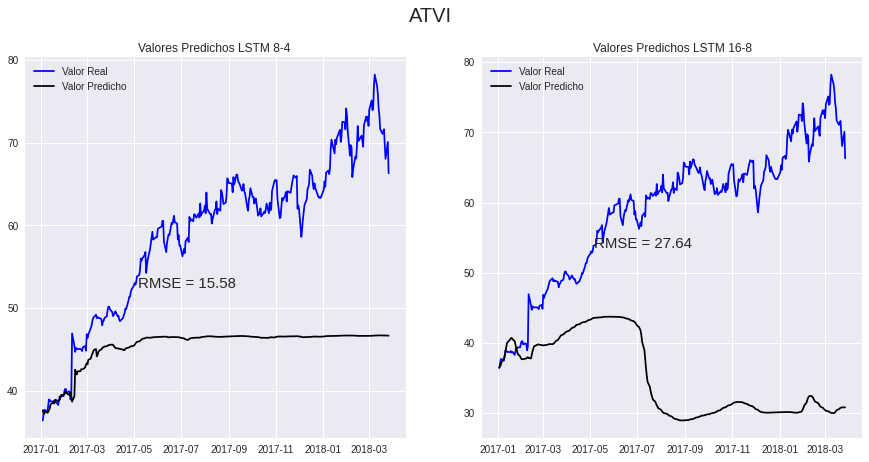

In [33]:
fig, axes = plt.subplots(1, 2,figsize=(15, 7))
fig.suptitle(tickers.Symbol[index],fontsize = 20)

# Plot de la LSTM 10-5
axes[0].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0].plot(index_time_t,predictedLSTM105, label="Valor Predicho", color = "black")
axes[0].legend()
axes[0].set_title('Valores Predichos LSTM 8-4 ')
axes[0].annotate('RMSE = %.2f'% rmseLSTM105, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM 16-8
axes[1].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1].plot(index_time_t,predictedLSTM168, label="Valor Predicho", color = "black")
axes[1].legend()
axes[1].set_title('Valores Predichos LSTM 16-8')
axes[1].annotate('RMSE = %.2f'% rmseLSTM168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)




plt.show()

Basandonos en los errores de entrenamiento decido que el mejor modelo para el activo MINI es el que tenga menor error, en este caso es el modelo de 16-8

Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [34]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos
predicted_stock_price = predictedR
# Es un margen movil, segun lo que busquemos
margen = 0.00
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({1.0: 186, -1.0: 121})


In [35]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado  valor     pred dif
2018-03-26      148469        0      0  70.08  46.6829  -1
Valor Final = 148469.07
Ganancia con margen = 48469.07


In [32]:
print(movimientos_alza)

           presupuesto acciones estado    valor     pred  dif
2017-01-03      100000        0      0  36.4204   37.641  NaN
2017-01-04      100000        0      0  37.1361  37.3082   -1
2017-01-05     23.8103     2651      1  37.7126   37.225    1
2017-01-06     99920.9        0     -1  37.6828  37.5013   -1
2017-01-09      15.073     2666      1  37.4741   37.373    1
2017-01-10      15.073     2666      0    38.15  37.4428    1
2017-01-11      15.073     2666      0  38.9651   37.669    1
2017-01-12      15.073     2666      0  38.8955   37.871    1
2017-01-13      15.073     2666      0  38.7166  38.3344    1
2017-01-17      103233        0     -1  38.7166  38.6546   -1
2017-01-18     20.1822     2657      1  38.8458  38.4701    1
2017-01-19      102652        0     -1  38.6271  38.9103   -1
2017-01-20      102652        0      0  38.7365  38.9011   -1
2017-01-23     10.8584     2680      1  38.2991  38.7614    1
2017-01-24     10.8584     2680      0  38.8657  38.8738    1
2017-01-

In [36]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      211355        0          1440      0  70.08  46.6829  -1
Valor Final = 110439.54
Ganancia con margen = 10439.54


In [50]:
print(movimientos_ab)

            presupuesto     acciones acciones_debo estado    valor     pred  \
2016-12-30           37         2610             0      0     38.3  42.7767   
2017-01-03       203252            0          2610     -1    38.93  42.6769   
2017-01-04       203252            0          2568      0    39.66  42.2528   
2017-01-05        36.24         2648             0      1    38.96  41.5931   
2017-01-06        36.24         2648             0      0    38.62  42.4012   
2017-01-09       203667            0          2648     -1    38.45  42.4629   
2017-01-10       203667            0          2587      0    38.36  42.2726   
2017-01-11       203667            0          2587      0       39  42.0309   
2017-01-12       203667            0          2587      0    38.52  41.9139   
2017-01-13       203667            0          2587      0    38.81  41.8959   
2017-01-17       203667            0          2587      0     37.8  41.7773   
2017-01-18       203667            0          2587  

In [140]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      174259        0          2019      0  44.35  42.4567  -1
Valor Final = 84716.80
Ganancia con margen = -15283.20


In [53]:
print(movimientos_baja)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  